Описание проекта

Вы работаете в IT-компании, которая выполняет на заказ проекты по машинному обучению. К вам обратился фермер, владелец молочного хозяйства «Вольный луг». Он хочет купить бурёнок, чтобы расширить поголовье стада коров. Для этого он заключил выгодный контракт с ассоциацией пастбищ «ЭкоФерма».

Условия позволяют фермеру очень тщательно отобрать коров. Он определяет качество молока по строгой методике, и при этом ему нужно выполнять свой план развития молочного хозяйства. Фермер хочет, чтобы каждая бурёнка давала не менее 6000 килограммов молока в год, а её надой был вкусным — строго по его критериям, ничуть не хуже. А продавцы и технологи так и норовят приукрасить своих коровок!

Поэтому он просит вас разработать модель машинного обучения, которая поможет ему управлять рисками и принимать объективное решение о покупке. «ЭкоФерма» готова предоставить подробные данные о своих коровах. Вам нужно создать две прогнозные модели для отбора бурёнок в поголовье:

Первая будет прогнозировать возможный удой коровы (целевой признак Удой);

Вторая — рассчитывать вероятность получить вкусное молоко от коровы (целевой признак Вкус молока).

С помощью модели нужно отобрать коров по двум критериям:
средний удой за год — не менее 6000 килограммов;
молоко должно быть вкусным.

## Загрузка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import seaborn as sns
import warnings
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import (accuracy_score,
                            confusion_matrix,
                            mean_absolute_error, mean_squared_error,
                            precision_score,
                            recall_score,
                            r2_score)
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [2]:
fm = pd.read_csv('/datasets/ferma_main.csv', sep=';',decimal=',')
fd = pd.read_csv('/datasets/ferma_dad.csv', sep=';',decimal=',')
cb = pd.read_csv('/datasets/cow_buy.csv', sep=';',decimal=',')
tables = [fm, fd, cb]

In [3]:
fm.sample(1)

,id,"Удой, кг",ЭКЕ (Энергетическая кормовая единица),"Сырой протеин, г",СПО (Сахаро-протеиновое соотношение),Порода,Тип пастбища,порода папы_быка,"Жирность,%","Белок,%",Вкус молока,Возраст
104,105,5700,14.4,1934,0.885,Вис Бик Айдиал,Равнинное,Соверин,3.57,3.079,вкусно,более_2_лет


In [4]:
fd.sample(1)

,id,Имя Папы
356,357,Барин


In [5]:
fd_names = {'Имя Папы':'имя папы'}
fd.rename(columns=fd_names, inplace=True)

In [6]:
cb.sample(1)

,Порода,Тип пастбища,порода папы_быка,Имя_папы,"Текущая_жирность,%","Текущий_уровень_белок,%",Возраст
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет


In [7]:
for table in tables:
    print('')
    print('----------------------------------------------------')
    print('Head of df')
    display(table.head())
    print('Info of df')
    display(table.info())
    print('Describe of df')
    display(table.describe().T)


----------------------------------------------------
Head of df


,id,"Удой, кг",ЭКЕ (Энергетическая кормовая единица),"Сырой протеин, г",СПО (Сахаро-протеиновое соотношение),Порода,Тип пастбища,порода папы_быка,"Жирность,%","Белок,%",Вкус молока,Возраст
0,1,5863,14.2,1743,0.890,Вис Бик Айдиал,Равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет
1,2,5529,12.8,2138,0.890,Вис Бик Айдиал,Равнинные,Соверин,3.54,3.079,вкусно,менее_2_лет
2,3,5810,14.0,1854,0.885,РефлешнСоверинг,Холмистое,Соверин,3.59,3.074,не вкусно,более_2_лет
3,4,5895,12.4,2012,0.885,РефлешнСоверинг,Холмистое,Айдиал,3.40,3.075,не вкусно,более_2_лет
4,5,5302,12.8,1675,0.885,Вис Бик Айдиал,Равнинные,Соверин,3.73,3.073,вкусно,менее_2_лет


Info of df
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634 entries, 0 to 633
Data columns (total 12 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   id                                     634 non-null    int64  
 1   Удой, кг                               634 non-null    int64  
 2   ЭКЕ (Энергетическая кормовая единица)  634 non-null    float64
 3   Сырой протеин, г                       634 non-null    int64  
 4   СПО (Сахаро-протеиновое соотношение)   634 non-null    float64
 5   Порода                                 634 non-null    object 
 6   Тип пастбища                           634 non-null    object 
 7   порода папы_быка                       634 non-null    object 
 8   Жирность,%                             634 non-null    float64
 9   Белок,%                                634 non-null    float64
 10  Вкус молока                            634 non-null    object 


None

Describe of df


,count,mean,std,min,25%,50%,75%,max
id,634.0,317.460568,183.096982,1.000,159.250,317.500,475.750,629.000
"Удой, кг",634.0,6187.025237,1638.401021,5204.000,5751.750,6130.500,6501.000,45616.000
ЭКЕ (Энергетическая кормовая единица),634.0,14.542744,1.301301,10.900,13.500,14.700,15.600,16.800
"Сырой протеин, г",634.0,1922.682965,182.392548,1660.000,1772.250,1880.500,2058.750,2349.000
СПО (Сахаро-протеиновое соотношение),634.0,0.912855,0.032209,0.840,0.890,0.930,0.940,0.960
"Жирность,%",634.0,3.603943,0.168020,2.990,3.590,3.650,3.720,3.750
"Белок,%",634.0,3.075666,0.002540,3.069,3.074,3.076,3.077,3.085



----------------------------------------------------
Head of df


,id,имя папы
0,1,Буйный
1,2,Соловчик
2,3,Барин
3,4,Буйный
4,5,Барин


Info of df
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629 entries, 0 to 628
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        629 non-null    int64 
 1   имя папы  629 non-null    object
dtypes: int64(1), object(1)
memory usage: 10.0+ KB


None

Describe of df


,count,mean,std,min,25%,50%,75%,max
id,629.0,315.0,181.72094,1.0,158.0,315.0,472.0,629.0



----------------------------------------------------
Head of df


,Порода,Тип пастбища,порода папы_быка,Имя_папы,"Текущая_жирность,%","Текущий_уровень_белок,%",Возраст
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет


Info of df
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Порода                   20 non-null     object 
 1   Тип пастбища             20 non-null     object 
 2   порода папы_быка         20 non-null     object 
 3   Имя_папы                 20 non-null     object 
 4   Текущая_жирность,%       20 non-null     float64
 5   Текущий_уровень_белок,%  20 non-null     float64
 6   Возраст                  20 non-null     object 
dtypes: float64(2), object(5)
memory usage: 1.2+ KB


None

Describe of df


,count,mean,std,min,25%,50%,75%,max
"Текущая_жирность,%",20.0,3.5775,0.126818,3.340,3.510,3.590,3.650,3.770
"Текущий_уровень_белок,%",20.0,3.0695,0.010339,3.046,3.064,3.074,3.076,3.081


In [8]:
for table in tables:
    display(table.isna().agg(['sum', 'mean']).T)

,sum,mean
id,0.0,0.0
"Удой, кг",0.0,0.0
ЭКЕ (Энергетическая кормовая единица),0.0,0.0
"Сырой протеин, г",0.0,0.0
СПО (Сахаро-протеиновое соотношение),0.0,0.0
Порода,0.0,0.0
Тип пастбища,0.0,0.0
порода папы_быка,0.0,0.0
"Жирность,%",0.0,0.0
"Белок,%",0.0,0.0


,sum,mean
id,0.0,0.0
имя папы,0.0,0.0


,sum,mean
Порода,0.0,0.0
Тип пастбища,0.0,0.0
порода папы_быка,0.0,0.0
Имя_папы,0.0,0.0
"Текущая_жирность,%",0.0,0.0
"Текущий_уровень_белок,%",0.0,0.0
Возраст,0.0,0.0


In [9]:
fm.columns.str.lower()

Index(['id', 'удой, кг', 'эке (энергетическая кормовая единица)',
       'сырой протеин, г', 'спо (сахаро-протеиновое соотношение)', 'порода',
       'тип пастбища', 'порода папы_быка', 'жирность,%', 'белок,%',
       'вкус молока', 'возраст'],
      dtype='object')

In [10]:
fm_names = {
    'ЭКЕ (Энергетическая кормовая единица)':'эке',
    'Сырой протеин, г':'протеин',
    'СПО (Сахаро-протеиновое соотношение)':'спо',
    'Жирность,%':'жирность',
    'Белок,%':'белок',
    'Удой, кг':'удой',
    'порода папы_быка':'порода быка',
    'Тип пастбища':'тип пастбища',
    'Возраст':'возраст',
    'Порода':'порода',
    'Вкус молока':'вкус молока'
}
fm.rename(columns=fm_names, inplace=True)

In [11]:
fm.head()

,id,удой,эке,протеин,спо,порода,тип пастбища,порода быка,жирность,белок,вкус молока,возраст
0,1,5863,14.2,1743,0.890,Вис Бик Айдиал,Равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет
1,2,5529,12.8,2138,0.890,Вис Бик Айдиал,Равнинные,Соверин,3.54,3.079,вкусно,менее_2_лет
2,3,5810,14.0,1854,0.885,РефлешнСоверинг,Холмистое,Соверин,3.59,3.074,не вкусно,более_2_лет
3,4,5895,12.4,2012,0.885,РефлешнСоверинг,Холмистое,Айдиал,3.40,3.075,не вкусно,более_2_лет
4,5,5302,12.8,1675,0.885,Вис Бик Айдиал,Равнинные,Соверин,3.73,3.073,вкусно,менее_2_лет


In [12]:
fd.head()

,id,имя папы
0,1,Буйный
1,2,Соловчик
2,3,Барин
3,4,Буйный
4,5,Барин


In [13]:
cb_names = {
    'Текущая_жирность,%':'жирность',
    'Текущий_уровень_белок,%':'белок',
    'Порода':'порода',
    'Тип пастбища':'тип пастбища',
    'Имя_папы':'имя папы',
    'Возраст':'возраст',
    'порода папы_быка':'порода быка'
}
cb.rename(columns=cb_names, inplace=True)

In [14]:
cb.head()

,порода,тип пастбища,порода быка,имя папы,жирность,белок,возраст
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет


In [15]:
for table in tables:
    print(table.duplicated().sum())

5
0
4


После первого взгляда на данные, стало очевидно, что есть большие проблемы с типами данных в разных колонках и таблицах, данную проблему будем решать на следующем этапе. Также видна еще одна проблема, вытекающая из неправильных типов данных. У вещественных чисел, вернее у объектов, которые должны были ими быть, вместо точки стоит запятая, что является ошибкой и при дальнейших вычислениях мы столкнемся с ошибками. Данную задачу я также переношу в следующий блок.

Однако, несмотря на вышеперечисленные ошибки, радует, что нет пропусков в данных, что от части выглядит подозрительным. Дополнительно стоит отметить, что на данном этапе я также проверил явные дубликаты, их оказалось немного, далее на следующем этапе я их удалю.

Дополнительно стоит отметить отдельно не только типы данных в столбцах, но и названия самих колонок, видно, что их названия не очень удобны для восприятия, поэтому я принял решение переименовать все неудачно названные столбцы. Если в будущем это как-либо навредит, я верну названия обратно.

На этом этап изучения данных заканчиваю.

Вовремя 1 этапа:
* Взглянул на таблицы
* Оценил масштаб таблиц
* Изучил столбцы, типы данных и значения в них
* Переименовал неудобно названные столбцы
* Оценил кол-во пропусков
* Обнаружил явные дубликаты

Все нюансы связанные с изменениями внутренних значений таблиц оставляю на следующий этап.

##  Предобработка данных

Основные задачи:
* Обработать явные дубликаты
* Обработать неявные дубликаты
* Обработать типы данных в столбцах
* Обработать числовые значения 

In [16]:
column_to_check = ['эке', 'протеин', 'жирность', 'белок', 'спо']
for tab in tables:
    for col in column_to_check:
        if col in tab.columns:
            tab[col] = tab[col].replace(',', '.', regex=True)
            tab[col] = tab[col].astype('float')

In [17]:
for table in tables:
    print(table.duplicated().sum())
    table = table.drop_duplicates()
    print(table.duplicated().sum())

5
0
0
0
4
0


Явные дубликаты удалены

In [18]:
fm.head(3)

,id,удой,эке,протеин,спо,порода,тип пастбища,порода быка,жирность,белок,вкус молока,возраст
0,1,5863,14.2,1743.0,0.890,Вис Бик Айдиал,Равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет
1,2,5529,12.8,2138.0,0.890,Вис Бик Айдиал,Равнинные,Соверин,3.54,3.079,вкусно,менее_2_лет
2,3,5810,14.0,1854.0,0.885,РефлешнСоверинг,Холмистое,Соверин,3.59,3.074,не вкусно,более_2_лет


In [19]:
print('порода', fm['порода'].unique())
print('тип пастбища', fm['тип пастбища'].unique())
print('порода быка', fm['порода быка'].unique())
print('вкус молока', fm['вкус молока'].unique())

порода ['Вис Бик Айдиал' 'РефлешнСоверинг']
тип пастбища ['Равнинное' 'Равнинные' 'Холмистое']
порода быка ['Айдиал' 'Соверин' 'Айдиалл']
вкус молока ['вкусно' 'не вкусно']


In [20]:
fm['тип пастбища'] = fm['тип пастбища'].replace('Равнинные', 'Равнинное')
fm['порода быка'] = fm['порода быка'].replace('Айдиалл', 'Айдиал')
fm['порода'] = fm['порода'].replace('Вис Бик Айдиал', 'Айдиал').replace('РефлешнСоверинг', 'Соверин')

In [21]:
print('порода', fm['порода'].unique())
print('тип пастбища', fm['тип пастбища'].unique())
print('порода быка', fm['порода быка'].unique())
print('вкус молока', fm['вкус молока'].unique())

порода ['Айдиал' 'Соверин']
тип пастбища ['Равнинное' 'Холмистое']
порода быка ['Айдиал' 'Соверин']
вкус молока ['вкусно' 'не вкусно']


In [22]:
cb.head(3)

,порода,тип пастбища,порода быка,имя папы,жирность,белок,возраст
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет


In [23]:
print('порода', cb['порода'].unique())
print('тип пастбища', cb['тип пастбища'].unique())
print('порода быка', cb['порода быка'].unique())

порода ['Вис Бик Айдиал' 'РефлешнСоверинг']
тип пастбища ['холмистое' 'равнинное']
порода быка ['Айдиал' 'Соверин']


In [24]:
cb['тип пастбища'] = cb['тип пастбища'].replace('Равнинные', 'Равнинное')
cb['порода быка'] = cb['порода быка'].replace('Айдиалл', 'Айдиал')
cb['порода'] = cb['порода'].replace('Вис Бик Айдиал', 'Айдиал').replace('РефлешнСоверинг', 'Соверин')

## Исследовательский анализ данных

Шаг 3. Исследовательский анализ данных

Проведите статистический анализ всех признаков.

Постройте графики для каждого признака. Помните, что количественным и категориальным признакам подходят разные графики.

Сделайте выводы о данных:
напишите, заметили ли вы выбросы, необычное распределение количественных признаков или другие особенности;
расскажите, как вы планируете улучшить данные.

Для количественных признаков лучше всего построить гистограмму распределения и ящик с усами. 

Для качественных признаков лучше строить столбчатые диаграммы

In [25]:
fm.head()

,id,удой,эке,протеин,спо,порода,тип пастбища,порода быка,жирность,белок,вкус молока,возраст
0,1,5863,14.2,1743.0,0.890,Айдиал,Равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет
1,2,5529,12.8,2138.0,0.890,Айдиал,Равнинное,Соверин,3.54,3.079,вкусно,менее_2_лет
2,3,5810,14.0,1854.0,0.885,Соверин,Холмистое,Соверин,3.59,3.074,не вкусно,более_2_лет
3,4,5895,12.4,2012.0,0.885,Соверин,Холмистое,Айдиал,3.40,3.075,не вкусно,более_2_лет
4,5,5302,12.8,1675.0,0.885,Айдиал,Равнинное,Соверин,3.73,3.073,вкусно,менее_2_лет


In [26]:
def create_plots(df, feature, name):
    plt.subplot(1,2,1)
    plt.suptitle(name)
    
    df[feature].plot(kind='hist', bins=10, figsize=(10, 6))
    plt.title('Гистограмма')
    plt.xlabel(name)
    plt.ylabel(None)
    plt.grid()
    
    plt.subplot(1, 2, 2)
    plt.boxplot(df[feature])
    plt.title('Boxplot')
    plt.xlabel(None)
    plt.grid()
    
    plt.show()

In [27]:
num_columns = ['удой', 'эке', 'протеин', 'жирность', 'белок', 'спо']
char_columns = ['порода', 'тип пастбища', 'порода быка', 'вкус молока', 'возраст']

In [28]:
fm[num_columns].describe().T

,count,mean,std,min,25%,50%,75%,max
удой,634.0,6187.025237,1638.401021,5204.000,5751.750,6130.500,6501.000,45616.000
эке,634.0,14.542744,1.301301,10.900,13.500,14.700,15.600,16.800
протеин,634.0,1922.682965,182.392548,1660.000,1772.250,1880.500,2058.750,2349.000
жирность,634.0,3.603943,0.168020,2.990,3.590,3.650,3.720,3.750
белок,634.0,3.075666,0.002540,3.069,3.074,3.076,3.077,3.085
спо,634.0,0.912855,0.032209,0.840,0.890,0.930,0.940,0.960


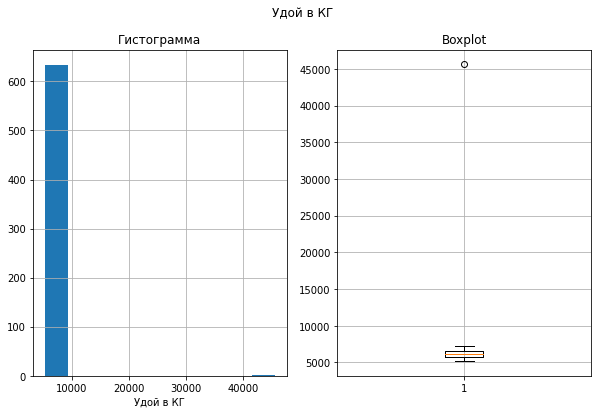

In [29]:
create_plots(fm, 'удой', 'Удой в КГ')

На графике есть едва заметное значение 40 000+ кг, то есть больше 40 тонн удоя. Следует узнать сколько таких значений есть, но судя по графику их немного и это просто выброс в данных.

У других параметров,судя по значениям выбросов не наблюдается, ниже постро также гистограммы и boxplot, чтобы в этом убедиться

In [30]:
fm.loc[fm['удой'] > 35000]

,id,удой,эке,протеин,спо,порода,тип пастбища,порода быка,жирность,белок,вкус молока,возраст
16,17,45616,11.5,1675.0,0.93,Айдиал,Холмистое,Айдиал,3.22,3.076,вкусно,более_2_лет


Как и оказалось такое значение во всей таблице всего одно, значит его можно с увренностью удалить

In [31]:
fm = fm.loc[fm['удой'] < 10000]

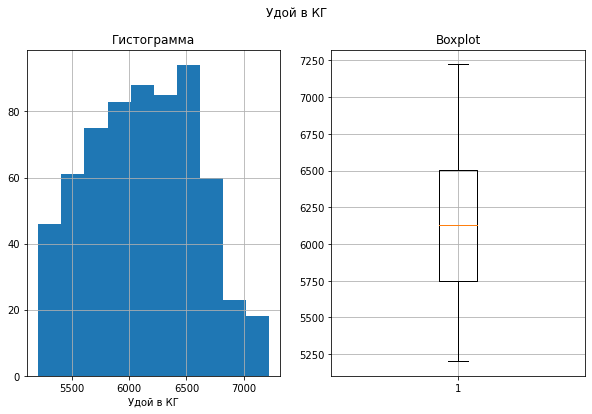

In [32]:
create_plots(fm, 'удой', 'Удой в КГ')

Очищенные значения выглядят намного лучше и яснее

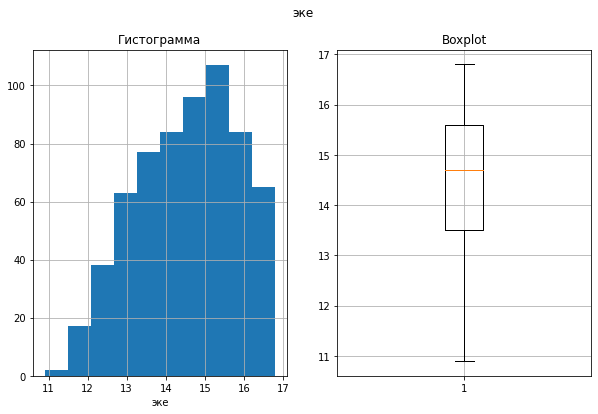

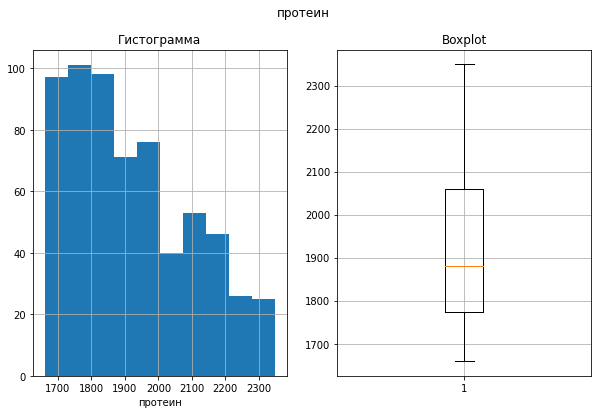

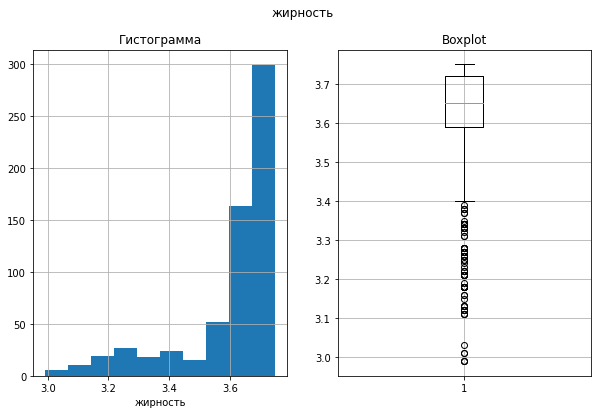

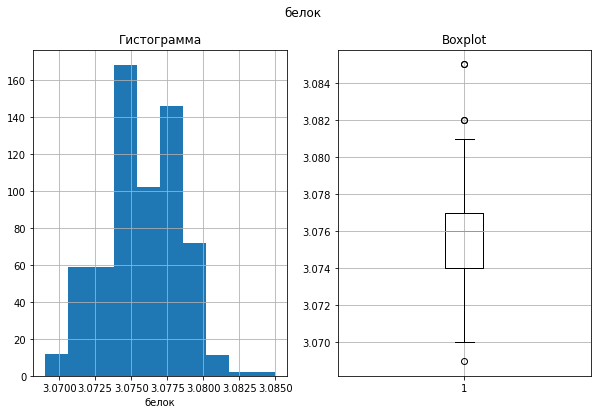

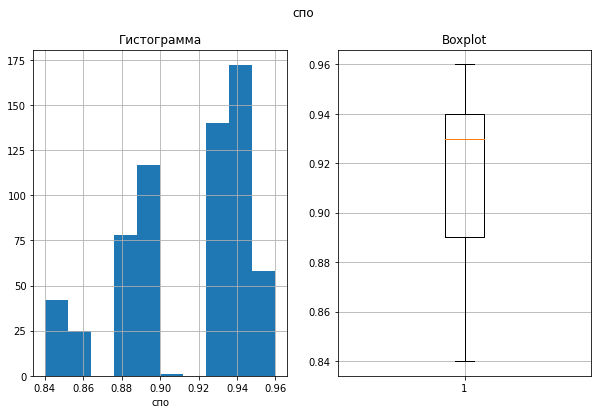

In [33]:
for i in range(1, len(num_columns)):
    create_plots(fm, num_columns[i], num_columns[i])

Стоит отметить графики по кол-ву белка, видно, что у гистограммы есть две пиковых точки. Далее, рассматривая boxplot, можно заметить необычные и подозрительные значения, которые сильно выбиваются на графике. Однако, если обратить внимание на то, как распределяются данные значения в формате чисел, а не графиков, складывается ощущение, что это просто редкие выбивающиеся значения. Но для красоты и полноты картины эти данные возможно стоит обработать.

Тоже самое стоит отметить и про жирность, в данном случае также очень много странных значений. От части таких значений, я также избавляюсь

Пройдем по порядку по каждому признаку.

#### Эке

В целом на мой взгляд данные распределены нормально, да есть выбивающиеся значения, но они не кажутся весомыми.

#### Протеин

Здесь очень сложно сказать, что распредление нормальное, скорее есть просто выбивающиеся значения, которых не так много, но мода и медианное значение сконцентрировано на отметках 1700 - 1900

#### Жирность

Как мы уже обсудили ниже, жирность по графику не распредлена нормально, однако относительно реальной жизни, значения не кажутся выбивающимися

#### Белок

В целом комментарий выше также описывает и кол-во белка

#### Спо

Значения СПО распредлены небольшими группами, между которыми просто "пропасть" в плане значений, возможно есть некий признак влияющий на кол-во СПО в молоке. Возможно разные породы или типы пастбищ.

In [34]:
length = len(fm.loc[(fm['белок'] < 3.082) & (fm['белок'] > 3.07)])

In [35]:
(len(fm) - length) / len(fm)

0.02527646129541864

In [37]:
def create_bars(df, feature):
    df.groupby(feature)['id'].count().plot(kind='bar', grid=True);
    plt.title(feature)
    plt.xlabel(None)
    plt.show()

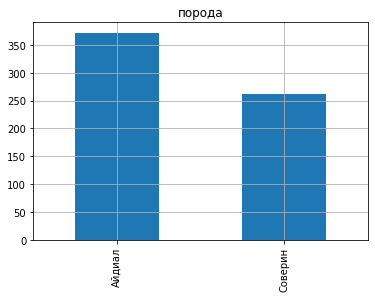

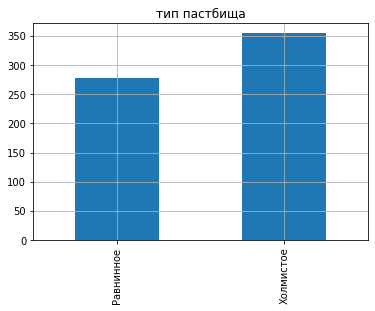

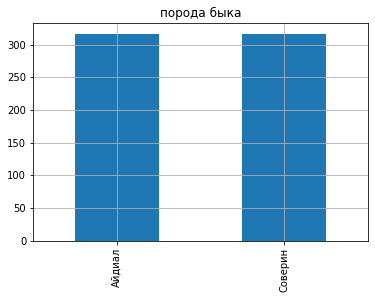

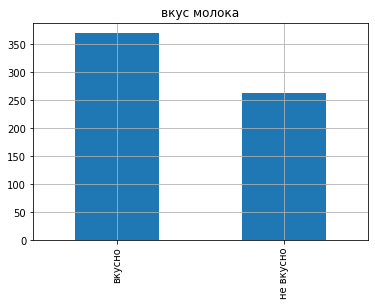

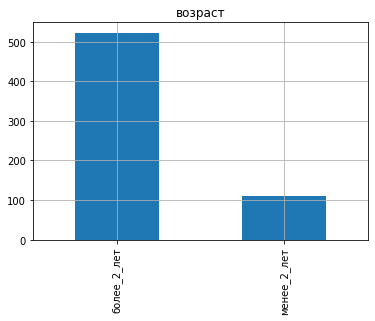

In [38]:
for i in char_columns:
    create_bars(fm, i)

## Корреляционный анализ

Шаг 4. 

Проведите корреляционный анализ признаков в датасете ferma_main.csv

Изучите взаимосвязь между признаками: рассчитайте коэффициенты корреляции между всеми признаками.

Постройте диаграммы рассеяния scatterplot для признака Удой, кг и всех количественных признаков с учётом значения категориальных признаков. Пример: диаграмма рассеяния для Удой, кг и Сырой протеин, г, цвет точек диаграммы отображает признак Порода.

Учитывайте, что виды связи в подгруппах могут различаться — например, для разных пород.
Сделайте выводы о взаимосвязи признаков.

Какой тип взаимосвязи между целевым и входными признаками?

Есть ли нелинейные связи между целевым и входными признаками? Нужно ли вводить в модель дополнительные признаки, чтобы это учесть?

Наблюдается ли мультиколлинеарность между входными признаками?

Для начала стоит построить матрицу корреляции, чтобы увидеть общую взаимосвязь между признакми.

In [39]:
#fm.corr()

In [40]:
!pip install phik 

     |████████████████████████████████| 686 kB 1.2 MB/s eta 0:00:01


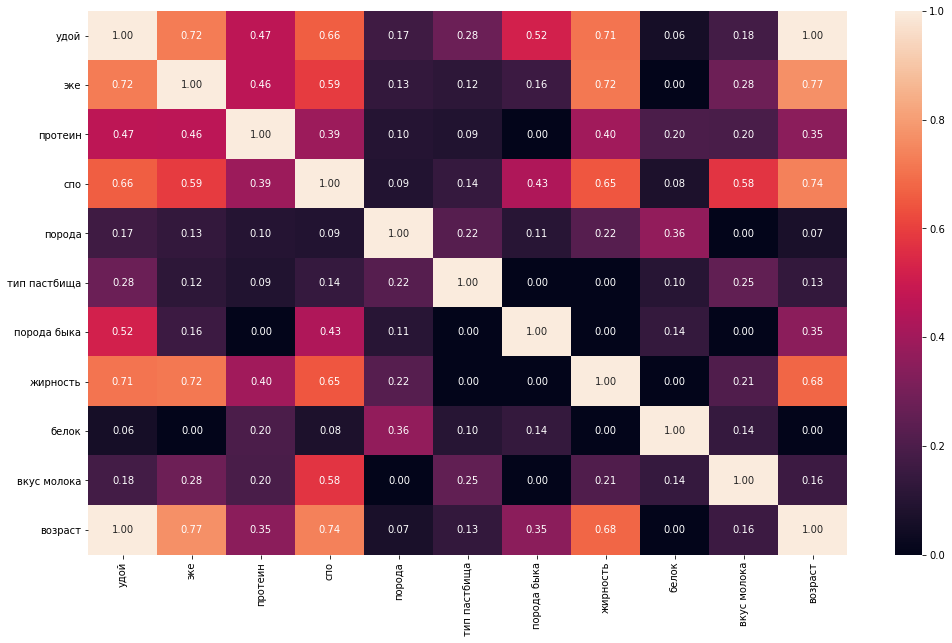

In [41]:
fm_for_research = fm
fm_for_corr = fm.drop('id', axis=1)
import phik
fig, ax = plt.subplots(figsize=(17, 10))
sns.heatmap(fm_for_corr.phik_matrix(interval_cols=['удой','эке','протеин','спо','жирность', 'белок']), annot=True, fmt='.2f');

Для лучше видимости создадим тепловую карту через библиотеку seaborn, которую я уже импортировал выше

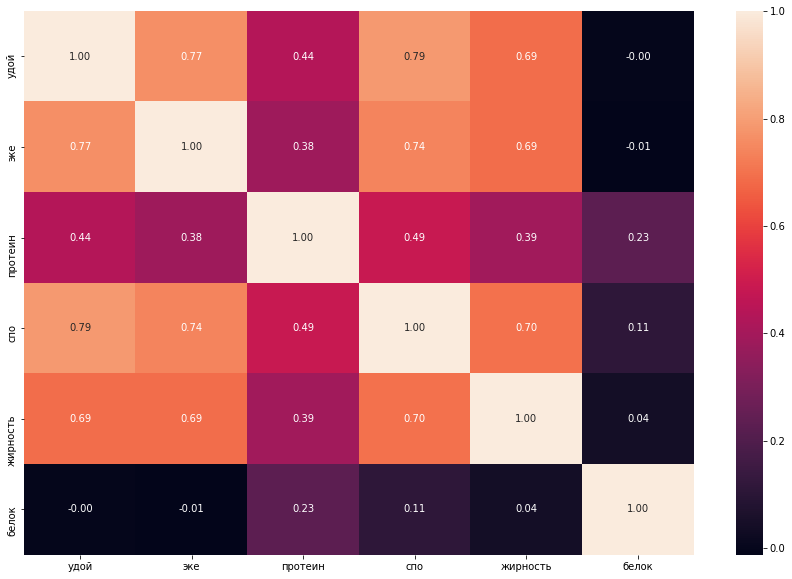

In [42]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(fm_for_corr.corr(method='spearman'),annot=True, fmt='.2f');

#### Удой 
- Между признаками Удой / эке И Удой / спо прослеживается высокая корреляция.
- Между признаками Удой / жирность прослеживается невысокая, но умеренная корреляция
- Между признаками Удой / протеин очень слабая корреляция.
- Между признаками Удой и белок корреляции нет совсем.

#### ЭКЕ
- Между признаками эке / спо И эке / Удой прослеживается высокая корреляция.
- Между признаками эке / жирность прослеживается невысокая, но умеренная корреляция
- Между признаками эке / протеин очень слабая корреляция.
- Между признаками эке и белок корреляции нет совсем.

#### Протеин
- Между всеми признаками и протеином значение корреляции очень низкое.

#### Спо
- Между признаками спо / Удой И спо / эке прослеживается высокая корреляция.
- Между признаками спо / жирность прослеживается невысокая, но умеренная корреляция
- Между признаками спо / протеин очень слабая корреляция.
- Между признаками спо и белок корреляции нет совсем.

#### Жирность
- Между признаками жирность/удой, жирность/эке, жирность/спо прослеживается невысокая, но умеренная корреляция
- Между признаками жирность / протеин очень слабая корреляция.
- Между признаками жирность и белок корреляции нет совсем.

#### Белок
- Между признаками белок и протеин есть очень маленькая корреляции.
- Между остальными параметрами корреляции нет совсем

In [43]:
def correlation(df, num):
    return df[num].corr(df['удой'])
    
def scatter_char(df, num, char):
    fig, ax = plt.subplots(figsize=(12, 6))
    sns.scatterplot(data=df, x=num, y='удой', hue=char)
    plt.title(f'Зависимость признаков Удой и {num}')
    plt.grid(True)
    plt.xlabel(num)
    plt.show()
    
    print(f'Значение корреляции {correlation(df, num)}')
    
def scatter(df, num):
    fig, ax = plt.subplots(figsize=(12, 6))
    sns.scatterplot(data=df, x=num, y='удой')
    plt.title(f'Зависимость признаков Удой и {num}')
    plt.grid(True)
    plt.xlabel(num)
    plt.show()
    
    print(f'Значение корреляции {correlation(df, num)}')

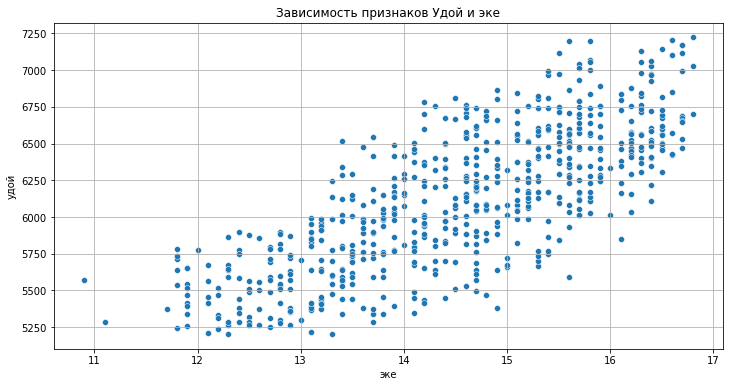

Значение корреляции 0.765029490592993


In [44]:
scatter(fm_for_research, 'эке');

* И по значению и по графику наблюдается высокая корреляция между признаками Удой и ЭКЕ

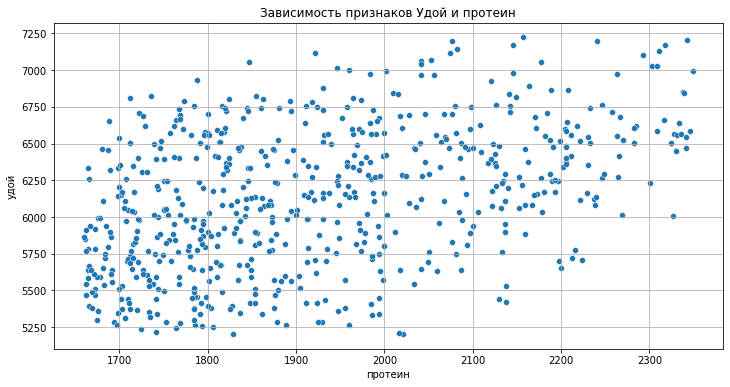

Значение корреляции 0.4473731892549825


In [45]:
scatter(fm_for_research, 'протеин');

* Между признаками Удой и Протеи, наблюдается небольшая корреляция. Однако высокой прямой зависимости нет. 

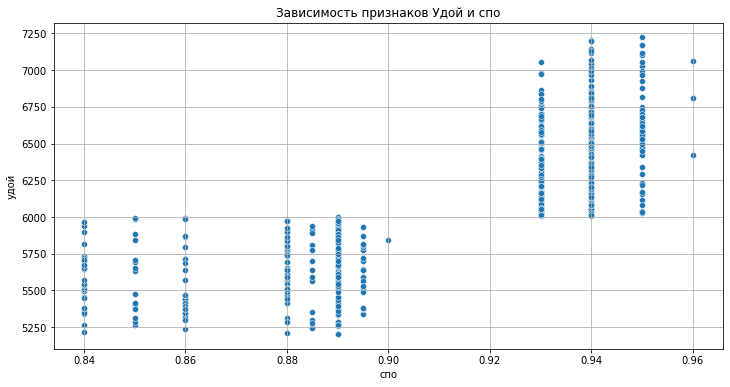

Значение корреляции 0.8053057572590419


In [46]:
scatter(fm_for_research, 'спо');

* Между значениями Удой и СПО наблюдается высокая корреляция. Об этом говорит и диаграмма рассеяния и значение корреляции.

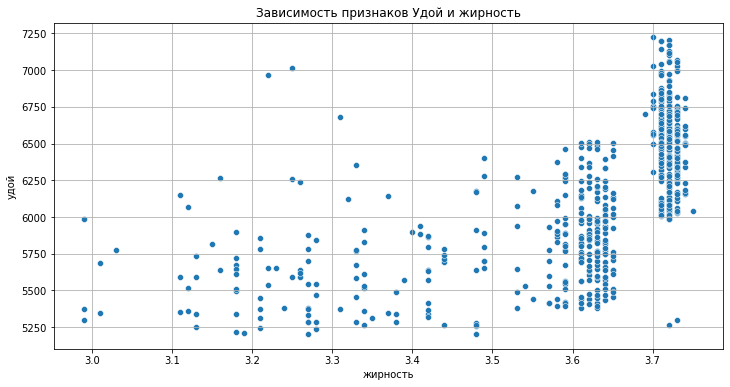

Значение корреляции 0.5999884157781767


In [47]:
scatter(fm_for_research, 'жирность');

* Между признаками Удой и Жирность прослеживается умеренная корреляция, это видно по вычесленному значению корреляции и построенному графику.

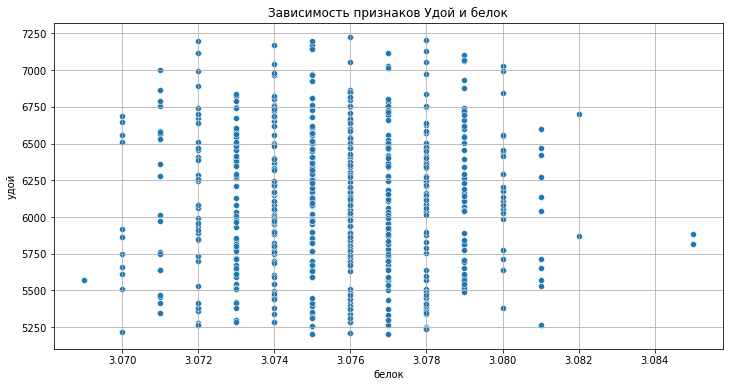

Значение корреляции 0.003644567263445517


In [48]:
scatter(fm_for_research, 'белок');

* Между признаками Удой и Белок не наблюдается корреляции.

<strong>Перейдем к поиску корреляции между категориальными признаками и удоем.</strong>

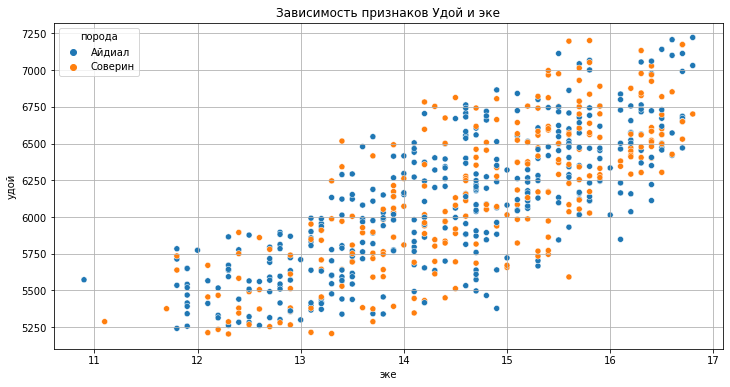

Значение корреляции 0.765029490592993


In [49]:
scatter_char(fm_for_research,'эке', 'порода')

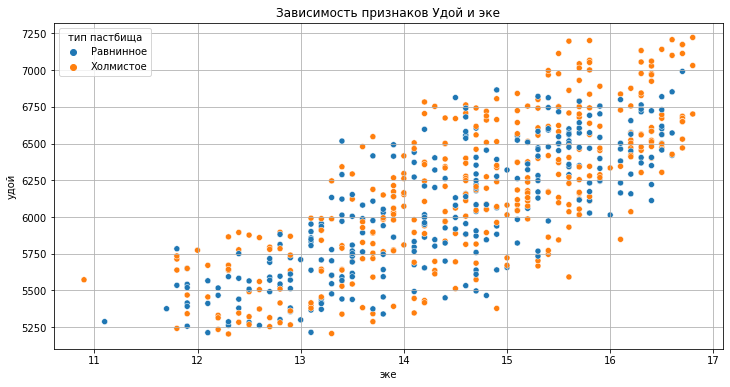

Значение корреляции 0.765029490592993


In [50]:
scatter_char(fm_for_research,'эке', 'тип пастбища')

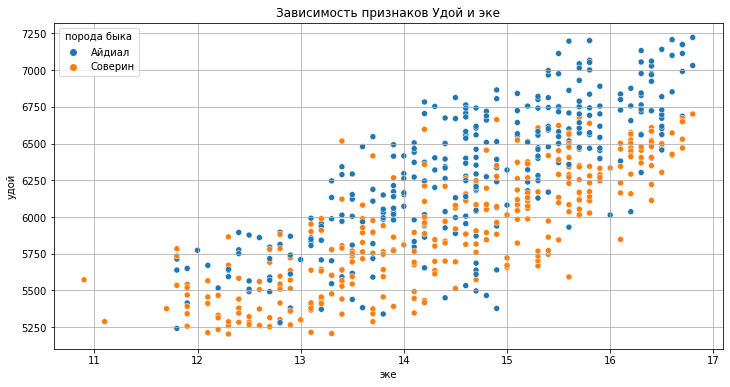

Значение корреляции 0.765029490592993


In [51]:
scatter_char(fm_for_research,'эке', 'порода быка')

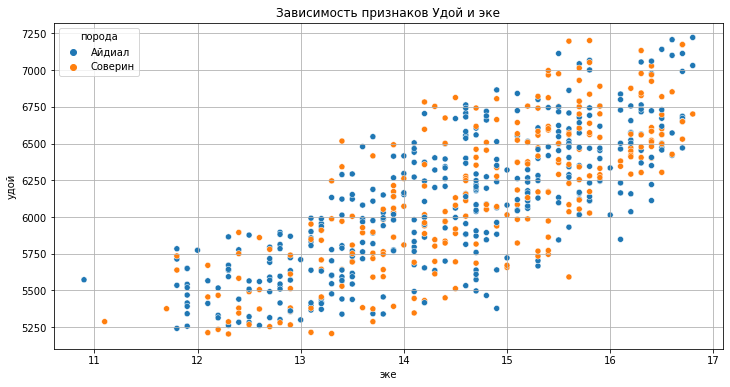

Значение корреляции 0.765029490592993


In [52]:
scatter_char(fm_for_research,'эке', 'порода')

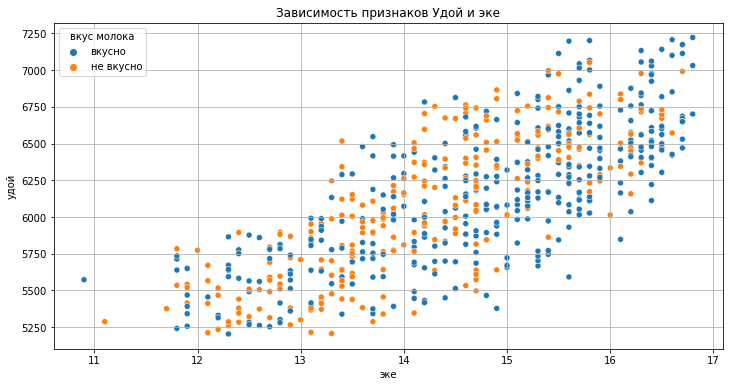

Значение корреляции 0.765029490592993


In [53]:
scatter_char(fm_for_research,'эке', 'вкус молока')

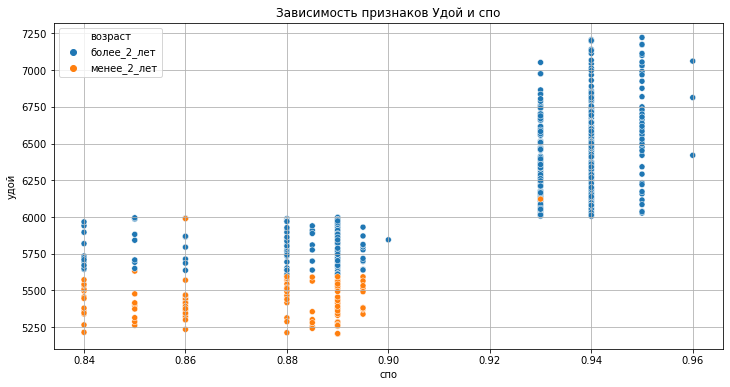

Значение корреляции 0.8053057572590419


In [54]:
scatter_char(fm_for_research,'спо', 'возраст')

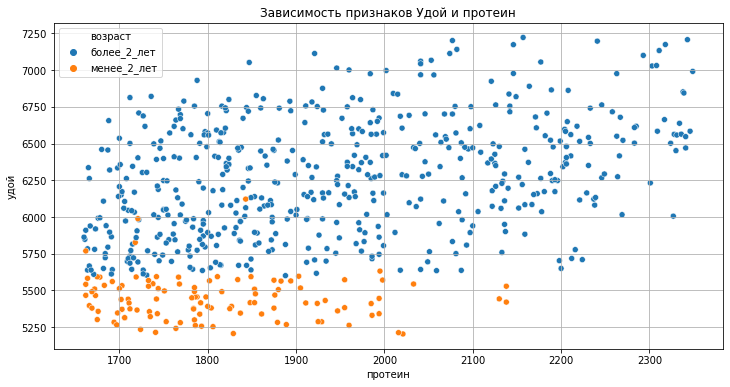

Значение корреляции 0.4473731892549825


In [55]:
scatter_char(fm_for_research,'протеин', 'возраст')

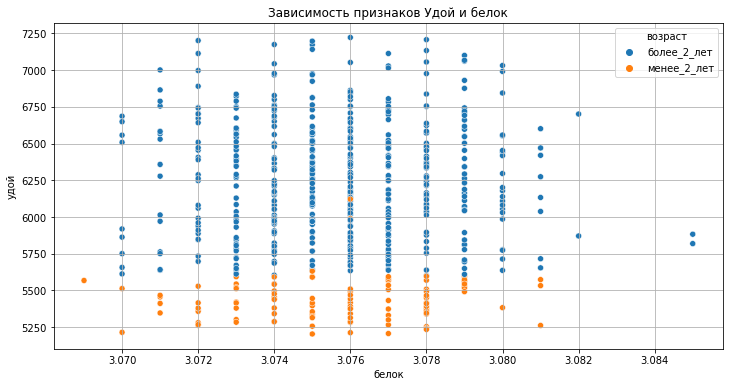

Значение корреляции 0.003644567263445517


In [56]:
scatter_char(fm_for_research,'белок', 'возраст')

На данном этапе у меня возникли трудности, я не понимаю как определить как связаны между собой признаки линейно или нелинейно.

Говоря о мультиколлинеарности, прочитав теорию из курса, я считаю, что на наших данных она отсутствует.

## Обучение модели линейной регрессии

Вам предстоит обучить три модели простой линейной регрессии.

Подготовьте данные датасета ferma_main.csv и обучите на них первую модель LinearRegression.
Используйте в качестве целевого признак Удой, кг.

Отберите признаки, которые подходят для модели линейной регрессии, аргументируйте выбор. Опирайтесь не только на наличие или отсутствие линейной связи между признаками, но и на причинно-следственные связи между удоем коров и группами признаков из описания датасета.

Разбейте данные на тренировочную и тестовую выборки.
Кодируйте категориальные признаки с помощью OneHotEncoder.
Масштабируйте количественные признаки с помощью StandardScaler.

Обучите модель линейной регрессии на подготовленных данных.
Оцените качество модели на тестовой выборке: рассчитайте R², проанализируйте остатки с помощью графиков.
Оформите выводы, укажите:
значение R² модели;
какие выводы следуют из анализа остатков;
нужны ли дополнительные исследования.

Подготовьте данные с учётом связи входных признаков с целевым и обучите на них вторую модель LinearRegression.
Посмотрите на диаграммы рассеяния: на них можно увидеть, что некоторые входные признаки связаны с целевым нелинейно. Исключите нелинейность, чтобы эти признаки были информативны для линейной регрессии. Вот несколько способов, которыми это можно сделать:
Вы обнаружите, что СПО и Удой связаны нелинейно. На их диаграмме рассеяния наблюдения сгруппированы в два кластера, причём есть такое значение СПО, которое можно считать границей между кластерами. Чтобы устранить нелинейность, преобразуйте СПО в категориальный бинарный признак, использовав эту границу.

Вы обнаружите, что ЭКЕ и Удой также связаны нелинейно. Нелинейность между ними можно исключить, если ввести новый признак ЭКЕ в квадрате.

Повторите шаги из пункта 1 и создайте вторую модель: подготовьте данные, обучите модель, оцените её качество и напишите выводы.
Добавьте в данные новый признак и обучите на них третью модель LinearRegression.
Добавьте признак Имя Папы из файла ferma_dad.csv, соединив его с остальными данными ferma_main.csv по ключу.
Устраните нелинейность между признаками.

Повторите шаги из пункта 1 и создайте третью модель: подготовьте данные, обучите модель, оцените её качество и напишите выводы.
Сравните качество трёх моделей линейной регрессии, сопоставьте их R² и остатки.
Оцените качество каждой модели по трём метрикам: MSE, MAE, RMSE. Используйте функции для расчёта метрик.
Выберите лучшую модель;

Укажите доверительный интервал прогноза лучшей модели. Для этого рассчитайте квантили ошибки модели на тренировочных данных.
С помощью лучшей модели спрогнозируйте удой коров, которых фермер хочет купить. Данные о них находятся в датасете cow_buy.csv.
Добавьте недостающие признаки ЭКЕ (Энергетическая кормовая единица), Сырой протеин, г и СПО (Сахаро-протеиновое соотношение): возьмите из датасета ferma_main.csv средние значения каждого из признаков и увеличьте их на 5%.
Выполните подготовку данных, аналогичную той, которую делали для тренировочной выборки.
Получите прогноз удоя коров.

Целевой признак - Удой

Входные признаки - эке, протеин, спо, порода, тип пастбища, возраст, порода папы.

In [57]:
ferma = fm_for_research
X = ferma[["эке", "протеин", "спо", "порода", "тип пастбища", "возраст", "порода быка"]]
Y = ferma['удой']

num_col_names = ['эке','протеин', 'спо']
cat_col_names = ['порода', 'тип пастбища','возраст', 'порода быка']

RANDOM_STATE=42

X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=RANDOM_STATE)

In [58]:
scaler = StandardScaler()

scaler.fit(X_train[num_col_names])

X_train_scaled = scaler.transform(X_train[num_col_names])
X_test_scaled = scaler.transform(X_test[num_col_names])

X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_col_names)


In [59]:
ohe = OneHotEncoder(drop='first', sparse=False)

ohe.fit(X_train[cat_col_names])

X_train_ohe = ohe.transform(X_train[cat_col_names])
X_test_ohe = ohe.transform(X_test[cat_col_names])

ohe_col_names = ohe.get_feature_names()

In [60]:
X_train_ohe = pd.DataFrame(X_train_ohe, columns=ohe_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=ohe_col_names)

In [61]:
X_train = pd.concat([X_train_scaled, X_train_ohe], axis=1)
X_test = pd.concat([X_test_scaled, X_test_ohe], axis=1)

In [62]:
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)
predictions = model_lr.predict(X_test)

In [63]:
r2 = r2_score(y_test, predictions)
print("r^2 =", r2)

r^2 = 0.7526889845143692


Значение r^2 равное 0.77 говорит о том что модели есть куда расти и она ошибается в 23 % случаев. Проанализируем остатки.

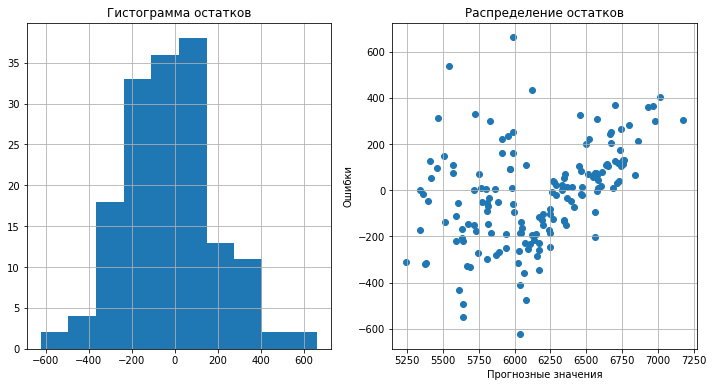

In [64]:
residuals = y_test - predictions

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].hist(residuals)
ax[0].grid()
ax[0].set_title('Гистограмма остатков')

ax[1].scatter(x=y_test, y=residuals)
ax[1].set_ylabel('Ошибки')
ax[1].set_xlabel('Прогнозные значения')
ax[1].grid()
ax[1].set_title('Распределение остатков');

Изучая, гистограмму остатков, можно сказать, что они распределены нормально со смещением влево. Это значит, что наша модель чаще предсказывает большие значения, чем они есть на самом деле.

Распределение также смещено немного влево, но сказать, что они плохо распрделены не могу.

Вот тут тоже хотелось бы попросить помощи и научиться правильно анализировать остатки с точки зрения дисперсии, если с гистограммой все ясно, то с рассеянием не очень

Подготовьте данные с учётом связи входных признаков с целевым и обучите на них вторую модель LinearRegression.
Посмотрите на диаграммы рассеяния: на них можно увидеть, что некоторые входные признаки связаны с целевым нелинейно. Исключите нелинейность, чтобы эти признаки были информативны для линейной регрессии. Вот несколько способов, которыми это можно сделать:
Вы обнаружите, что СПО и Удой связаны нелинейно. На их диаграмме рассеяния наблюдения сгруппированы в два кластера, причём есть такое значение СПО, которое можно считать границей между кластерами. Чтобы устранить нелинейность, преобразуйте СПО в категориальный бинарный признак, использовав эту границу.

Вы обнаружите, что ЭКЕ и Удой также связаны нелинейно. Нелинейность между ними можно исключить, если ввести новый признак ЭКЕ в квадрате.

Повторите шаги из пункта 1 и создайте вторую модель: подготовьте данные, обучите модель, оцените её качество и напишите выводы.

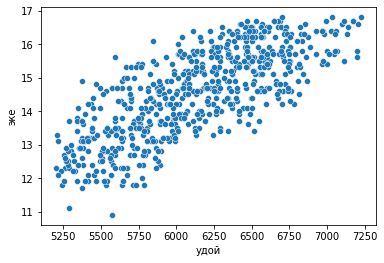

In [65]:
sns.scatterplot(data=ferma, x='удой', y='эке');

In [66]:
ferma['экеКВ'] = ferma['эке'] ** 2

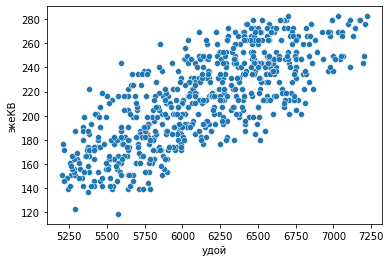

In [67]:
sns.scatterplot(data=ferma, x='удой', y='экеКВ');

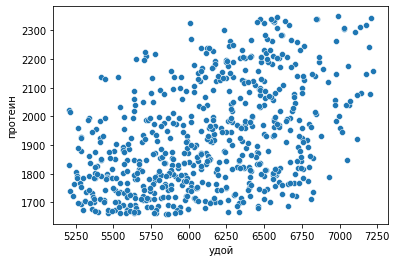

In [68]:
sns.scatterplot(data=ferma, x='удой', y='протеин');

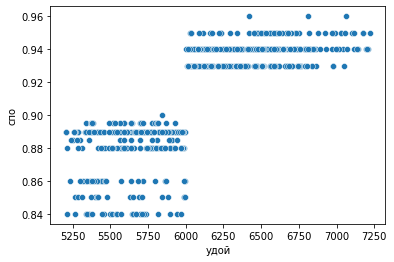

In [69]:
sns.scatterplot(data=ferma, x='удой', y='спо');

In [70]:
ferma['спо'].describe()

count    633.000000
mean       0.912828
std        0.032227
min        0.840000
25%        0.890000
50%        0.930000
75%        0.940000
max        0.960000
Name: спо, dtype: float64

преобразуем входной признак 'спо' в категориальный, судя по графику и описанию, 50% значений больше и меньше значения 0.93

Это значит, что 0 станут значения меньше 0.93 и 1 те, что больше

In [71]:
ferma['спо_cat'] = ferma['спо'].apply(lambda x: 'High' if x >= 0.93 else 'Low')

In [72]:
ferma['спо_cat'].value_counts()

High    370
Low     263
Name: спо_cat, dtype: int64

In [73]:
X = ferma[["экеКВ", "протеин", "спо_cat", "порода", "тип пастбища", "возраст", "порода быка"]]
Y = ferma['удой']

num2_col_names = ['экеКВ','протеин']
cat2_col_names = ['порода', 'тип пастбища','возраст', 'порода быка', 'спо_cat']

RANDOM_STATE=42

X_train2, X_test2, y_train2, y_test2 = train_test_split(X, Y, random_state=RANDOM_STATE)

scaler_2 = StandardScaler()

scaler_2.fit(X_train2[num2_col_names])

X_train2_scaled = scaler_2.transform(X_train2[num2_col_names])
X_test2_scaled = scaler_2.transform(X_test2[num2_col_names])

X_train2_scaled = pd.DataFrame(X_train2_scaled, columns=num2_col_names)
X_test2_scaled = pd.DataFrame(X_test2_scaled, columns=num2_col_names)

ohe_2 = OneHotEncoder(drop='first', sparse=False)

ohe_2.fit(X_train2[cat2_col_names])

X_train2_ohe = ohe_2.transform(X_train2[cat2_col_names])
X_test2_ohe = ohe_2.transform(X_test2[cat2_col_names])

ohe2_col_names = ohe_2.get_feature_names()

X_train2_ohe = pd.DataFrame(X_train2_ohe, columns=ohe2_col_names)
X_test2_ohe = pd.DataFrame(X_test2_ohe, columns=ohe2_col_names)

X_train2 = pd.concat([X_train2_scaled, X_train2_ohe], axis=1)
X_test2 = pd.concat([X_test2_scaled, X_test2_ohe], axis=1)

model_lr_2 = LinearRegression()
model_lr_2.fit(X_train2, y_train2)
predictions_2 = model_lr_2.predict(X_test2)

In [74]:
r2_2 = r2_score(y_test2, predictions_2)
print("r^2 =", r2_2)

r^2 = 0.7903877940199926


Теперь метрика R^2 имеет значение 0.82. Это значит, что модель стало лучше отрабатывать на наших данных. И возведение эке в квадрат и преобразование входного признака спо в категориальный признак, улучшило нашу модель.

Также рассмотрим графики.

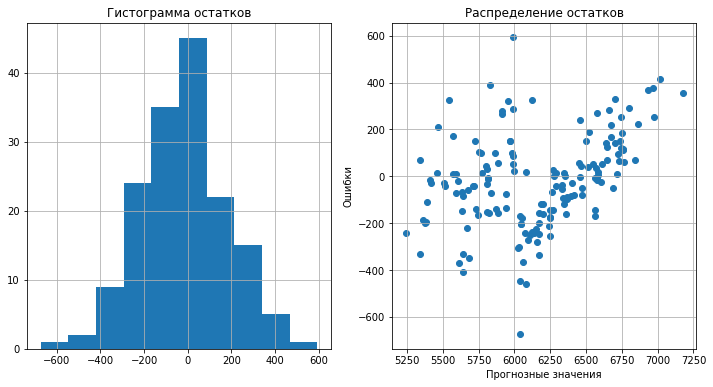

In [75]:
residuals_2 = y_test2 - predictions_2

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].hist(residuals_2)
ax[0].grid()
ax[0].set_title('Гистограмма остатков')

ax[1].scatter(x=y_test2, y=residuals_2)
ax[1].set_ylabel('Ошибки')
ax[1].set_xlabel('Прогнозные значения')
ax[1].grid()
ax[1].set_title('Распределение остатков');

остатки все еще распределены нормально, центр перестал быть смещен влево, однако большая часть данных все еще концентрируется слева.

Добавьте в данные новый признак и обучите на них третью модель LinearRegression.

Добавьте признак Имя Папы из файла ferma_dad.csv, соединив его с остальными данными ferma_main.csv по ключу.

Устраните нелинейность между признаками.

In [76]:
fd

,id,имя папы
0,1,Буйный
1,2,Соловчик
2,3,Барин
3,4,Буйный
4,5,Барин
...,...,...
624,625,Буйный
625,626,Барин
626,627,Барин
627,628,Барин


In [77]:
ferma_new = ferma.merge(fd, on='id')
ferma_new

,id,удой,эке,протеин,спо,порода,тип пастбища,порода быка,жирность,белок,вкус молока,возраст,экеКВ,спо_cat,имя папы
0,1,5863,14.2,1743.0,0.890,Айдиал,Равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет,201.64,Low,Буйный
1,2,5529,12.8,2138.0,0.890,Айдиал,Равнинное,Соверин,3.54,3.079,вкусно,менее_2_лет,163.84,Low,Соловчик
2,3,5810,14.0,1854.0,0.885,Соверин,Холмистое,Соверин,3.59,3.074,не вкусно,более_2_лет,196.00,Low,Барин
3,4,5895,12.4,2012.0,0.885,Соверин,Холмистое,Айдиал,3.40,3.075,не вкусно,более_2_лет,153.76,Low,Буйный
4,5,5302,12.8,1675.0,0.885,Айдиал,Равнинное,Соверин,3.73,3.073,вкусно,менее_2_лет,163.84,Low,Барин
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
628,627,5970,14.4,1837.0,0.880,Соверин,Холмистое,Соверин,3.64,3.075,не вкусно,более_2_лет,207.36,Low,Барин
629,627,5970,14.4,1837.0,0.880,Соверин,Холмистое,Соверин,3.64,3.075,не вкусно,более_2_лет,207.36,Low,Барин
630,627,5970,14.4,1837.0,0.880,Соверин,Холмистое,Соверин,3.64,3.075,не вкусно,более_2_лет,207.36,Low,Барин
631,628,5746,13.8,1994.0,0.890,Соверин,Равнинное,Соверин,3.64,3.077,вкусно,более_2_лет,190.44,Low,Барин


In [78]:
X = ferma_new[["экеКВ", "протеин", "спо_cat", "порода", "тип пастбища", "возраст", "порода быка", 'имя папы']]
Y = ferma_new['удой']

num3_col_names = ['экеКВ','протеин']
cat3_col_names = ['порода', 'тип пастбища','возраст', 'порода быка', 'спо_cat', 'имя папы']

RANDOM_STATE=42

X_train3, X_test3, y_train3, y_test3 = train_test_split(X, Y, random_state=RANDOM_STATE)

scaler_3 = StandardScaler()

scaler_3.fit(X_train3[num3_col_names])

X_train3_scaled = scaler_3.transform(X_train3[num3_col_names])
X_test3_scaled = scaler_3.transform(X_test3[num3_col_names])

X_train3_scaled = pd.DataFrame(X_train3_scaled, columns=num3_col_names)
X_test3_scaled = pd.DataFrame(X_test3_scaled, columns=num3_col_names)

ohe_3 = OneHotEncoder(drop='first', sparse=False)

ohe_3.fit(X_train3[cat3_col_names])

X_train3_ohe = ohe_3.transform(X_train3[cat3_col_names])
X_test3_ohe = ohe_3.transform(X_test3[cat3_col_names])

ohe3_col_names = ohe_3.get_feature_names()

X_train3_ohe = pd.DataFrame(X_train3_ohe, columns=ohe3_col_names)
X_test3_ohe = pd.DataFrame(X_test3_ohe, columns=ohe3_col_names)

X_train3 = pd.concat([X_train3_scaled, X_train3_ohe], axis=1)
X_test3 = pd.concat([X_test3_scaled, X_test3_ohe], axis=1)

model_lr_3 = LinearRegression()
model_lr_3.fit(X_train3, y_train3)
predictions_3 = model_lr_3.predict(X_test3)

In [79]:
r2_3 = r2_score(y_test3, predictions_3)
print("r^2 =", r2_3)

r^2 = 0.8023577428031078


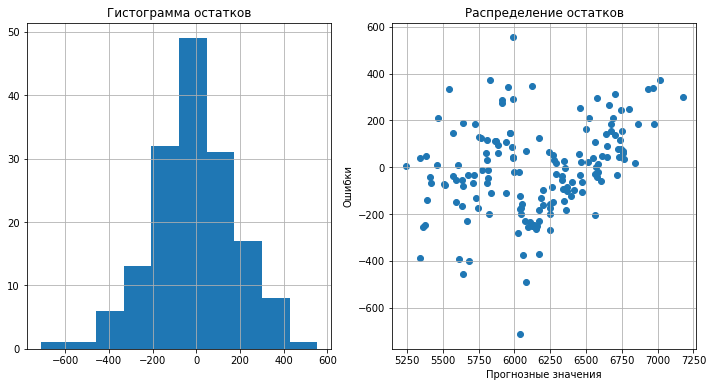

In [80]:
residuals_3 = y_test3 - predictions_3

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].hist(residuals_3)
ax[0].grid()
ax[0].set_title('Гистограмма остатков')

ax[1].scatter(x=y_test3, y=residuals_3)
ax[1].set_ylabel('Ошибки')
ax[1].set_xlabel('Прогнозные значения')
ax[1].grid()
ax[1].set_title('Распределение остатков');

Оцените качество каждой модели по трём метрикам: MSE, MAE, RMSE. Используйте функции для расчёта метрик.
Выберите лучшую модель;
Укажите доверительный интервал прогноза лучшей модели. Для этого рассчитайте квантили ошибки модели на тренировочных данных.

In [81]:
mse_1 = mean_squared_error(y_test, predictions)
rmse_1 = mean_squared_error(y_test, predictions, squared=False)
mae_1 = mean_absolute_error(y_test, predictions)
print('MSE_1 = ', mse_1)
print('RMSE_1 = ', rmse_1)
print('MAE_1 = ', mae_1)

MSE_1 =  46380.33204021292
RMSE_1 =  215.36093434096378
MAE_1 =  169.06871932227762


In [82]:
mse_2 = mean_squared_error(y_test, predictions_2)
rmse_2 = mean_squared_error(y_test, predictions_2, squared=False)
mae_2 = mean_absolute_error(y_test, predictions_2)
print('MSE_2 = ', mse_2)
print('RMSE_2 = ', rmse_2)
print('MAE_2 = ', mae_2)

MSE_2 =  39310.3545911367
RMSE_2 =  198.26839029743672
MAE_2 =  153.90727729391546


In [83]:
mse_3 = mean_squared_error(y_test, predictions_3)
rmse_3 = mean_squared_error(y_test, predictions_3, squared=False)
mae_3 = mean_absolute_error(y_test, predictions_3)
print('MSE_3 = ', mse_3)
print('RMSE_3 = ', rmse_3)
print('MAE_3 = ', mae_3)

MSE_3 =  37065.52858540836
RMSE_3 =  192.52409871340356
MAE_3 =  148.84232234555324


Посчитаем доверительный интервал

Укажите доверительный интервал прогноза лучшей модели. Для этого рассчитайте квантили ошибки модели на тренировочных данных.

In [84]:
errors = residuals_3
quantiles=(0.025, 0.975)

lower_quantile = np.quantile(errors, quantiles[0])
upper_quantile = np.quantile(errors, quantiles[1])

print(f"Доверительный интервал прогноза: [{lower_quantile}, {upper_quantile}]")

Доверительный интервал прогноза: [-394.54969844725844, 343.1561705187484]


С помощью лучшей модели спрогнозируйте удой коров, которых фермер хочет купить. Данные о них находятся в датасете cow_buy.csv.
Добавьте недостающие признаки ЭКЕ (Энергетическая кормовая единица), Сырой протеин, г и СПО (Сахаро-протеиновое соотношение): возьмите из датасета ferma_main.csv средние значения каждого из признаков и увеличьте их на 5%.
Выполните подготовку данных, аналогичную той, которую делали для тренировочной выборки.
Получите прогноз удоя коров.


In [85]:
cow_buy = cb

In [86]:
eke = ferma_new['эке'].mean()
spo = ferma_new['спо'].mean()
sp = ferma_new['протеин'].mean()

cow_buy['эке'] = eke * 1.05
cow_buy['протеин'] = sp * 1.05
cow_buy['спо'] = spo * 1.05

# cow_buy[['эке,' 'спо,' 'протеин']] = \
#                 cow_buy[['эке,' 'спо,' 'протеин']].mean()*1.05

cb_copy = cb.copy()
cb_copy['спо'] = cb['спо'].apply(lambda x: 'high' if x < 0.92 else 'low')
cb_copy['экеКВ'] = cb['эке'].apply(lambda x: x**2)

In [87]:
encoder = OneHotEncoder(drop='first', sparse=False)
cat_col_names = ['спо', 'порода', 'тип пастбища', 'возраст', 'порода быка', 'имя папы']
cb_ohe = encoder.fit_transform(cb_copy[cat_col_names])
encoder_col_names = encoder.get_feature_names()

cb_ohe = pd.DataFrame(cb_ohe, columns=encoder_col_names)

In [88]:
scaler = StandardScaler()
num_col_names = ['экеКВ', 'протеин']
cb_scaled = scaler.fit_transform(cb_copy[num_col_names])

cb_scaled = pd.DataFrame(cb_scaled, columns=num_col_names)

cb_new = pd.concat([cb_ohe, cb_scaled], axis=1)
cb_new.insert(loc=0,
                   column='x0_low',
                   value = 0.0)
cb_new

,x0_low,x1_Соверин,x2_холмистое,x3_менее_2_лет,x4_Соверин,x5_Буйный,x5_Геркулес,x5_Соловчик,экеКВ,протеин
0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,-1.0
1,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,-1.0
2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-1.0
3,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,-1.0
4,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-1.0
5,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,-1.0
6,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,-1.0
7,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,-1.0
8,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-1.0
9,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,-1.0


In [89]:
cb_new.columns = ['спо_low',
                       'порода_Соверинг',
                       'тип пастбища_холмистое',
                       'возраст_менее_2_лет',
                       'порода папы_Соверинг',
                       'имя папы_Буйный',
                       'имя папы_Геркулес',
                       'имя папы_Соловчик',
                       'экеКВ',
                       'протеин']

cow_buy['удой'] = model_lr_3.predict(cb_new)

In [90]:
Cow_buy = cow_buy[cow_buy['удой'] >= 6000]

## Обучение модели логистической регрессии

Подготовьте данные датасета ferma_main.csv и обучите на них модель LogisticRegression.

Используйте в качестве целевого признак Вкус молока.

При необходимости преобразуйте имеющиеся или добавьте новые признаки.

Разбейте данные на тренировочную и тестовую выборки.

Кодируйте категориальные признаки с помощью OneHotEncoder.
Масштабируйте количественные признаки с помощью StandardScaler.
Обучите модель логистической регрессии на подготовленных данных.

Оцените качество модели на тестовой выборке: рассчитайте метрики accuracy, recall, precision.
Постройте матрицу ошибок.
Проанализируйте модель логистической регрессии.

Объясните, какая ошибка критичнее всего при покупке коров: первого или второго рода. Помните, что главное для заказчика — вкусное молоко.
Сформулируйте ответ с учётом метрик recall и precision, выберите более важную из них.

Сведите критичную ошибку к нулю: для этого измените порог принадлежности к классам. Ещё раз рассчитайте значения метрик recall и precision. Какое значение порога вы выбрали? Как изменились значения метрик?

Оформите выводы: скажите, что нужно сделать дальше, исходя из анализа модели?
С помощью обученной модели спрогнозируйте вкус молока коров, которых фермер хочет купить. Данные о них находятся в датасете cow_buy.csv.
Выполните подготовку данных, аналогичную той, которую делали для тренировочной выборки.
Получите прогноз вкуса молока коров.

In [91]:
ferma_new

,id,удой,эке,протеин,спо,порода,тип пастбища,порода быка,жирность,белок,вкус молока,возраст,экеКВ,спо_cat,имя папы
0,1,5863,14.2,1743.0,0.890,Айдиал,Равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет,201.64,Low,Буйный
1,2,5529,12.8,2138.0,0.890,Айдиал,Равнинное,Соверин,3.54,3.079,вкусно,менее_2_лет,163.84,Low,Соловчик
2,3,5810,14.0,1854.0,0.885,Соверин,Холмистое,Соверин,3.59,3.074,не вкусно,более_2_лет,196.00,Low,Барин
3,4,5895,12.4,2012.0,0.885,Соверин,Холмистое,Айдиал,3.40,3.075,не вкусно,более_2_лет,153.76,Low,Буйный
4,5,5302,12.8,1675.0,0.885,Айдиал,Равнинное,Соверин,3.73,3.073,вкусно,менее_2_лет,163.84,Low,Барин
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
628,627,5970,14.4,1837.0,0.880,Соверин,Холмистое,Соверин,3.64,3.075,не вкусно,более_2_лет,207.36,Low,Барин
629,627,5970,14.4,1837.0,0.880,Соверин,Холмистое,Соверин,3.64,3.075,не вкусно,более_2_лет,207.36,Low,Барин
630,627,5970,14.4,1837.0,0.880,Соверин,Холмистое,Соверин,3.64,3.075,не вкусно,более_2_лет,207.36,Low,Барин
631,628,5746,13.8,1994.0,0.890,Соверин,Равнинное,Соверин,3.64,3.077,вкусно,более_2_лет,190.44,Low,Барин


In [92]:
ferma_new['тип пастбища'] = [x.lower() for x in ferma_new['тип пастбища']]

In [93]:
ferma_new['вкус молока'] = ferma_new['вкус молока'].apply(lambda x: 1 if x == 'вкусно' else 0)
ferma_new

,id,удой,эке,протеин,спо,порода,тип пастбища,порода быка,жирность,белок,вкус молока,возраст,экеКВ,спо_cat,имя папы
0,1,5863,14.2,1743.0,0.890,Айдиал,равнинное,Айдиал,3.58,3.076,1,более_2_лет,201.64,Low,Буйный
1,2,5529,12.8,2138.0,0.890,Айдиал,равнинное,Соверин,3.54,3.079,1,менее_2_лет,163.84,Low,Соловчик
2,3,5810,14.0,1854.0,0.885,Соверин,холмистое,Соверин,3.59,3.074,0,более_2_лет,196.00,Low,Барин
3,4,5895,12.4,2012.0,0.885,Соверин,холмистое,Айдиал,3.40,3.075,0,более_2_лет,153.76,Low,Буйный
4,5,5302,12.8,1675.0,0.885,Айдиал,равнинное,Соверин,3.73,3.073,1,менее_2_лет,163.84,Low,Барин
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
628,627,5970,14.4,1837.0,0.880,Соверин,холмистое,Соверин,3.64,3.075,0,более_2_лет,207.36,Low,Барин
629,627,5970,14.4,1837.0,0.880,Соверин,холмистое,Соверин,3.64,3.075,0,более_2_лет,207.36,Low,Барин
630,627,5970,14.4,1837.0,0.880,Соверин,холмистое,Соверин,3.64,3.075,0,более_2_лет,207.36,Low,Барин
631,628,5746,13.8,1994.0,0.890,Соверин,равнинное,Соверин,3.64,3.077,1,более_2_лет,190.44,Low,Барин


In [94]:
display(X.head(1))
display(Y.head(1))

,экеКВ,протеин,спо_cat,порода,тип пастбища,возраст,порода быка,имя папы
0,201.64,1743.0,Low,Айдиал,Равнинное,более_2_лет,Айдиал,Буйный


0    5863
Name: удой, dtype: int64

In [95]:
display(X_train.head(1))
display(X_test.head(1))
display(y_train.head(1))
display(y_test.head(1))

,эке,протеин,спо,x0_Соверин,x1_Холмистое,x2_менее_2_лет,x3_Соверин
0,0.830184,-0.749938,0.548257,0.0,1.0,0.0,1.0


,эке,протеин,спо,x0_Соверин,x1_Холмистое,x2_менее_2_лет,x3_Соверин
0,-0.694152,-0.055649,-0.992192,0.0,0.0,0.0,1.0


608    6405
Name: удой, dtype: int64

330    5989
Name: удой, dtype: int64

In [96]:
y = ferma_new['вкус молока']
X = ferma_new.drop(['id', 'удой', 'вкус молока','эке'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_STATE)

num_col_names = ['экеКВ', 'протеин', 'жирность', 'белок']
cat_col_names = ['спо_cat', 'порода быка', 'имя папы', 'тип пастбища', 'возраст', 'порода']

encoder = OneHotEncoder()
scaler_cat = StandardScaler()

encoder = OneHotEncoder(drop='first', sparse=False)
encoder.fit(X_train[cat_col_names])
X_train_encode = encoder.transform(X_train[cat_col_names])
X_test_encode = encoder.transform(X_test[cat_col_names])

encode_names = encoder.get_feature_names()

X_train_encode = pd.DataFrame(X_train_encode, columns=encode_names)
X_test_encode = pd.DataFrame(X_test_encode, columns=encode_names)

scaler_cat.fit(X_train[num_col_names])
X_train_scaled = scaler_cat.transform(X_train[num_col_names])
X_test_scaled = scaler_cat.transform(X_test[num_col_names])

X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_col_names)

X_train = pd.concat([X_train_scaled, X_train_encode], axis=1)
X_test = pd.concat([X_test_scaled, X_test_encode], axis=1)

In [97]:
X_test

,экеКВ,протеин,жирность,белок,x0_Low,x1_Соверин,x2_Буйный,x2_Геркулес,x2_Соловчик,x3_холмистое,x4_менее_2_лет,x5_Соверин
0,-0.725539,-0.055649,0.696102,-0.698352,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1.418130,1.845381,0.757125,1.312698,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.023271,-0.953816,-0.097199,-0.296142,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
3,-0.580026,-0.342181,-1.378686,0.910488,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,-0.939827,-0.766468,0.085870,-0.296142,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
154,0.101073,-1.146674,0.207916,-1.100562,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
155,-1.080029,-0.623202,0.024847,-1.100562,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
156,0.258270,-0.408303,-0.768454,-1.100562,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
157,-1.010193,-1.212797,-1.805848,0.910488,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0



<div class="alert alert-success">
<h2> Комментарий ревьюера #2 <a class="tocSkip"> </h2>

👍 Прошу прощения, видимо, недосмотрел.
    
</div>
  

In [98]:
clf = LogisticRegression()

clf = clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

In [99]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
print('Accuracy = ', round(accuracy, 3))
print('Precision = ', round(precision, 3))
print('Recall = ', round(recall, 3))

Accuracy =  0.642
Precision =  0.65
Recall =  0.851


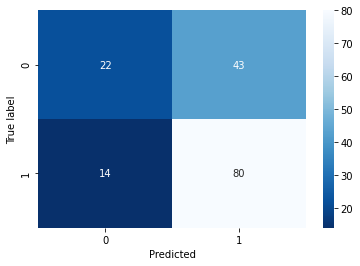

In [100]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r')
plt.ylabel('True label')
plt.xlabel('Predicted'); 

Accuracy почти 66% данных она правильно разделяет по классам, не слишком большой результат, есть куда улучшать модель.

Precision 68%, то есть по сути в 30% случаев наша модель ложно определяет объекты к 1 классу 

Однако судя по recall наша модель достаточно хорошо определяет объекты 1 класса

Заказчику нужно, чтобы молоко было вкусным, то есть нужно минимизировать ошибки 2 рода, нам не нужны коровы, с не вкунсым молоком, то есть модель должна правильно отнести корову к классу 1

Нам нужно работать с метрикой recall 

<div class="alert alert-block alert-danger">
<h2><s> Комментарий ревьюера <a class="tocSkip"></h2>
  
<b>На доработку🤔:</b>

Ошибки второго рода − ложноотрицательные. Если нам нужно минимизировать ложноположительные ошибки (то есть, когда модель назначает молоко вкусным, хотя оно таковым не является), тогда нам нужна другая метрика.

<div class="alert alert-info">
Получается, что нужно работать с precision, до сих пор не получается построить в голове нормальный алгоритм определения метрики, над которой нужно работать и как правльно понять, какую ошибку нужно уменьшать.

Сначала у меня в голове была мысль, что нам нужно сделать так, чтобы у нас модель правильно относила, грубо говоря, 1 к 1, а 0 к 0, но судя по всему это немного не так
</div>

<div class="alert alert-success">
<h2> Комментарий ревьюера 2<a class="tocSkip"> </h2>
 
👍 Давай проговорим про порог. Кажется, здесь на самом деле нет никаких подводных камней, это банально простая операция в одну строку, но для нее важно понимать, что мы считаем в метриках и что нам выдают модели. 
    
***
    
Итак, здесь нужно избегать ситуации, когда модель предсказала «хорошо», а на самом деле «плохо», то есть минимизируем ложноположительные ошибки. 
    
(вот мем, чтобы запомнить, какую ошибку какой считаем: https://chemicalstatistician.wordpress.com/2014/05/12/applied-statistics-lesson-of-the-day-type-i-error-false-positive-and-type-2-error-false-negative/ )    
    
Допустим, у нас llm, чатGPT-5, как бы мы сформулировали для модели наш промпт? 
    
Обратимся сначала к заданию: фермер не хочет рисковать, хочет покупать коров, которые 100% ему подойдут.
    
Тогда наш промпт может быть таким: Классифицируй строки по вкусу, отнеси к «вкусному» молоко только тогда, когда очень сильно уверена в своих предсказаниях. Не уверена − не рискуй.
    
***
    
Ок, а теперь вернемся к нашей самой неглубокой в мире нейросети − логистической регрессии. 
    
Наша логистическая регрессия на самом деле вполне себе привычная линейная модель. Она принимает на вход признаки, подбирает к ним веса и выдает некоторые предсказания. В случае линейной регрессии предсказания − это наши ответы для количественной величины (удоя). В случае логистической, предсказания будут некоторыми промежуточными итогами − логитами. Мы их засовываем в функцию сигмоиды, чтобы они приобрели размерность от нуля до единицы, а дальше уловно считаем эти значения на выходе из сигмоиды вероятностями классов. Когда мы испольуем predict, то отсекаем вероятности по порогу в 0.5 и получаем собственно классы предсказания. Но никто нам не мешает использовать вероятности через predict_proba() и дальше самим устанавливать порог, по которому отсекаем классы.
    
То есть, использование порога будет выглядеть так: берем вероятности, сравниваем с порогом, если вероятность выше, пишем, что класс «1», ниже − «0». 
    
***
    
Выше мы вывели качество через predict и увидели, что у нас слишком много ложноположительных ошибок. Мы помним, что хотим сказать модели «относи молоко к вкусному только если очень сильно в этом уверена», чтобы минимизировать ложноположительные ошибки. 
    
Тогда логично в коде это пропиасть как повышение порога классификации. 
    
Все, вот по смыслу порога это, вероятно, полная информация. Никаких больше подводных камней нет.
 
***
    
НЕ ТЕРЯЕМ АДЕКВАТНОСТЬ
    
По порогу есть такое небольшое замечание. Порог мы подбираем под нашу обучающую выборку. Если представим, что у нас будет выборка в миллион строк, то всегда найдется такая, которая выдаст ошибку даже при вероятности класса в 99%. Какая-нибудь корова с некорректными измерениями параметров, при этом мы ее не отследим в анализе выбросов и аномалий. Поэтому здесь не следует четко отслеживать порог без единой ложноположительной ошибки. Можно взять порог и ниже, когда количество ошибок почти нулевое, 1-2% от общего числа наблюдений (или в нашем случае 3-5 ошибок).
    
***
    
КАК УЙТИ ОТ ДЕЛЕНИЯ НА НОЛЬ
    
С precision у нас будет небольшая оптимизационная проблема, которая связана с тем, что чем ближе эта метрика к единице, тем меньше у нас будет наблюдений для вычисления метрики. Помним, в метрике у нас только положительные ответы модели (TP/TP+FP), чем выше порог, тем реже модель их дает. В итоге если модель не даст ни одного ответа, то у нас возникнет деление на ноль. А если модель будет давать 2-3 ответа, то от каждого из них метрика может скакать очень сильно. Если будем подбирать порог в цикле, то это увидим. Я рекомендую попробовать подбор именно в цикле. 

В этом проекте можно игнорировать такой недостаток нестабильности метрики, но если нам нужно запрограммировать автоподбор порога, то рекомендуется использовать метрику specificity, которую отсчитываем от негативных предсказаний, но в знаменателе у нас все тот же FP, который, таким образом будет обратно пропорционален значению метрики (максимизируем метрику, минимизируем FP). В итоге метрика стабильна. Делает она то же самое − минимизирует ложноположительную ошибку.
    
***
    
КАК ЗАПОМНИТЬ ФОРМУЛЫ
    
Вообще, заметь по формулам, все они имеют одну и ту же структуру. То, что мы хотим минимизировать, находится в знаменателе. Но просто так мы его взять не можем, поэтому накидываем еще что-то (одно и то же) в числитель и знаменатель. 
    
Для accuracy минимизируем любые ложные ответы. Тогда берем в знаменатель FP+FN, а докидываем в числитель и знаменатель TP+TN. 
    
Для полноты минимизируем ложноотрицательные (не хотим, чтобы модель пропускала положительные ответы), докидываем в числитель и знаменатель TP.
    
В precision тоже докидываем TP, но минимизируем FP. Все, если это уложилось, можно больше не заучивать наизусть метрики. 
    
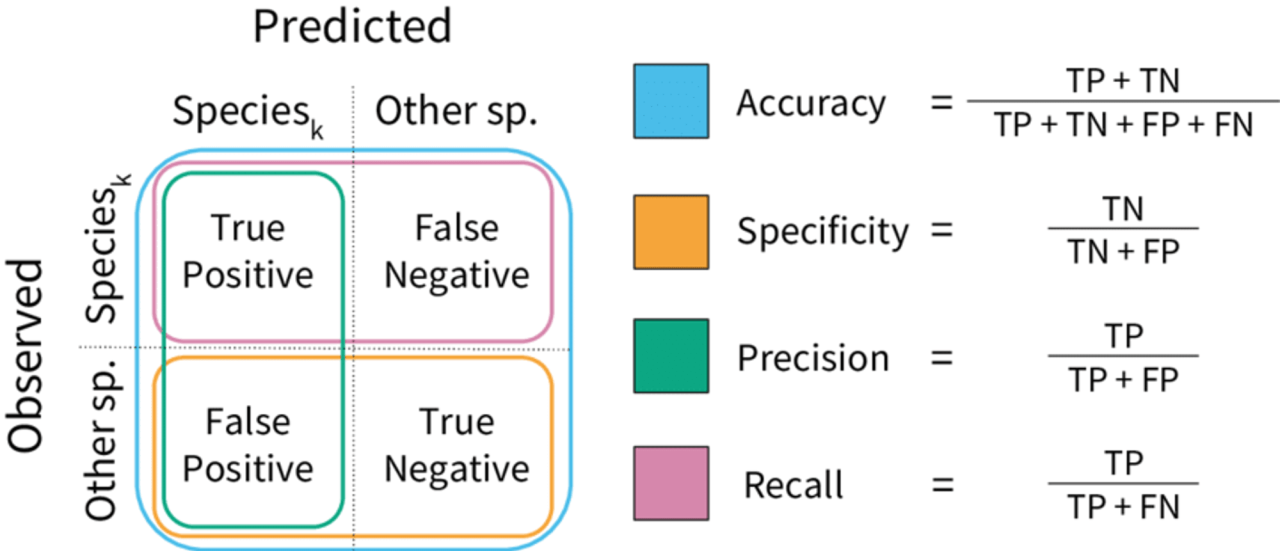
    


</div>  

<div class="alert alert-info"> 
    Супер спасибо большое за пояснение, еще немного опыта и практики и уверен, что все уложится, спасибо большое
</div>

<div class="alert alert-success">
<h2> Комментарий ревьюера #3 <a class="tocSkip"> </h2>

👍 Ага, еще буквально пару задач и должно уложиться. Это запоминается быстро.
</div>

In [101]:
thresholds = [round(i,2) for i in np.linspace(0.1,1,num = 10,endpoint=False)]

y_proba = clf.predict_proba(X_test)[:,1]

data = pd.DataFrame(zip(y_test, y_proba),
             columns = ['y_valid', 'y_proba']).sort_values(by='y_proba',ascending=False)

columns = []
for i in thresholds:
    columns.append('y_pred_'+str(i))
    data['y_pred_'+str(i)] = data['y_proba'].apply(lambda x: 1 if x >= i else 0)
    
data.head()

,y_valid,y_proba,y_pred_0.1,y_pred_0.19,y_pred_0.28,y_pred_0.37,y_pred_0.46,y_pred_0.55,y_pred_0.64,y_pred_0.73,y_pred_0.82,y_pred_0.91
145,1,0.882262,1,1,1,1,1,1,1,1,1,0
66,1,0.848503,1,1,1,1,1,1,1,1,1,0
69,1,0.841362,1,1,1,1,1,1,1,1,1,0
116,1,0.840599,1,1,1,1,1,1,1,1,1,0
55,1,0.826546,1,1,1,1,1,1,1,1,1,0


Я вообще на этом моменте вылетел, я не понимаю, что нужно сделать, я понимаю, что мы должны уменьшить ошибку 2 рода, засчет сдвига порога классификации. я застрял на этом моменте

<div class="alert alert-block alert-danger">
<h2><S> Комментарий ревьюера <a class="tocSkip"></h2>
  
<b>На доработку🤔:</b>

Важно явно посчитать порог, чтобы понимать, что мы выбрали наиболее оптимальный. Оптимизировать будем не recall, а precision. То есть, порог буде повышать относительно 0.5. 
    
Важно найти такой порог, при котором precision будет максимальной.
    
Можно сделать в цикле:

```
probabilities_one_valid = clf.predict_proba(X_test)[:,1]
    
for i in np.arange(0.5, 0.9, 0.02).round(2):
    y_pred = probabilities_one_valid > i
    print('порог: ', i, 'precision: ', precision_score(y_test, y_pred))
```       

Либо вывести отсортированный список вероятностей, тогда по первой ошибкам увидим, какой порог будет оптимальным.

```

y_proba = model_lr_1.predict_proba(X_test4)[:,1]

data = pd.DataFrame(zip(y_test, y_proba),
             columns = ['y_valid', 'y_proba']).sort_values(by='y_proba',ascending=False)

print(data.head(20)) 

```

Либо сразу автоматически вывести то, что нам нужно:

```

porog = 0.5
while True:
    porog+=0.001
    pred = (logreg.predict_proba(X_test)[:,1] >= porog).astype('bool')
    if precision_score(y_test, pred) == 1:
        break
porog

```

Либо взять индекс элемента с максимальным значением precision:

```


probs = logreg_model.predict_proba(X_test)[:, 1]
precision, _, thresholds = precision_recall_curve(y_test, probs)

precision_threshold = thresholds[np.argmax(precision)]

print(f"Оптимальное пороговое значение: {precision_threshold}")

```

В коде выше неточность, там список с метриками на одно значение короче, поэтому нужно взять предыдущий индекс (но не перепутать с индексом предыдущего элемента). 

</div>


In [102]:
probabilities_one_valid = clf.predict_proba(X_test)[:,1]

for i in np.arange(0.5, 0.9, 0.02).round(2):
    y_pred = probabilities_one_valid > i
    print('порог: ', i, 'precision: ', precision_score(y_test, y_pred))

порог:  0.5 precision:  0.6504065040650406
порог:  0.52 precision:  0.646551724137931
порог:  0.54 precision:  0.6728971962616822
порог:  0.56 precision:  0.717391304347826
порог:  0.58 precision:  0.7159090909090909
порог:  0.6 precision:  0.7215189873417721
порог:  0.62 precision:  0.7323943661971831
порог:  0.64 precision:  0.8
порог:  0.66 precision:  0.8571428571428571
порог:  0.68 precision:  0.8536585365853658
порог:  0.7 precision:  0.8378378378378378
порог:  0.72 precision:  0.8235294117647058
порог:  0.74 precision:  0.8076923076923077
порог:  0.76 precision:  0.8947368421052632
порог:  0.78 precision:  0.8666666666666667
порог:  0.8 precision:  0.9
порог:  0.82 precision:  1.0
порог:  0.84 precision:  1.0
порог:  0.86 precision:  1.0
порог:  0.88 precision:  1.0


<div class="alert alert-info">
При таких данных максимальный precision мы получаем при пороге в 0.82 
</div>

<div class="alert alert-success">
<h2> Комментарий ревьюера #2 <a class="tocSkip"> </h2>

👍 Верно.
</div>

Далее я понимаю, что нам нужно будет создать еще одну модель, ее также нужно откалибровать, далее параметры удоя не меньше 6000 кг, и вкусное молоко


 <div class="alert alert-block alert-danger">
<h2><s> Комментарий ревьюера <a class="tocSkip"></h2>
  
<b>На доработку🤔:</b>
    
Нет, модель у нас уже есть выше. При изменении порога модель не меняется. Поэтому можем использовать уже имеющуюся у нас модель, просто нужно будет применить ранее найденный порог. 
    
Вместо `model.predict()` нужно будет брать `predict_proba()`, вероятности класса сравниваем с порогом и если вероятность выше, говорим, что молоко вкусное по прогнозу.

 


In [103]:
cow_to_buy = cow_buy.copy()
cow_buy = cow_buy[cow_buy['удой'] >= 6000]

In [104]:
cow_buy

,порода,тип пастбища,порода быка,имя папы,жирность,белок,возраст,эке,протеин,спо,удой
3,Соверин,холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет,15.274929,2019.227962,0.958469,6201.462217
4,Соверин,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет,15.274929,2019.227962,0.958469,6180.783305
9,Соверин,холмистое,Айдиал,Буйный,3.40,3.079,менее_2_лет,15.274929,2019.227962,0.958469,6254.046006
10,Айдиал,холмистое,Соверин,Соловчик,3.73,3.055,более_2_лет,15.274929,2019.227962,0.958469,6195.232903
15,Соверин,холмистое,Айдиал,Буйный,3.40,3.065,более_2_лет,15.274929,2019.227962,0.958469,6201.462217
16,Айдиал,холмистое,Соверин,Соловчик,3.73,3.079,более_2_лет,15.274929,2019.227962,0.958469,6195.232903
19,Соверин,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет,15.274929,2019.227962,0.958469,6180.783305


<div class="alert alert-info">
Не понимаю, как это в коде реализовать... Подскажи пожалуйста
    
</div>

<div class="alert alert-block alert-danger" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
<h2><s> Комментарий ревьюера #2 <a class="tocSkip"></h2>
  
<b>На доработку🤔:</b>
 
Выше мы обучили модель, скелер и энкодер. Здесь они все нам понадобятся.
    
Для начала нужно посмотреть на структуру нашей таблицы, на которой мы обучали модель. Выведем одну строку:

</div>

 



In [105]:
# код ревьюера
display(X.head(1))
display(cow_buy.head(1))

,протеин,спо,порода,тип пастбища,порода быка,жирность,белок,возраст,экеКВ,спо_cat,имя папы
0,1743.0,0.89,Айдиал,равнинное,Айдиал,3.58,3.076,более_2_лет,201.64,Low,Буйный


,порода,тип пастбища,порода быка,имя папы,жирность,белок,возраст,эке,протеин,спо,удой
3,Соверин,холмистое,Айдиал,Буйный,3.4,3.061,более_2_лет,15.274929,2019.227962,0.958469,6201.462217


<div class="alert alert-warning">
<h2> Комментарий ревьюера  #2 <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации💡:</b> 

Ага, нам нужно, чтобы в обеих таблицах колонки шли в нужном порядке и признаки были одними и теми же.
    
Тогда здесь нужно будет перевесте ЭКе в экеКВ, спо в спо_cat. Логичнее их также и назвать (ниже называешь иначе).
    
```
    
cow_buy['экеКВ'] = cow_buy['эке'].apply(lambda x: x**2)
cow_buy['спо_cat'] = cow_buy['спо'].apply(lambda x: 'High' if x>0.92 else 'Low')
    
```
    
Затем переставить колонки строго в том же порядке.
    
`cow_buy = cow_buy[X.columns]` - переставлять можно как-то так, я сейчас не пробовал, могу где-то допустить неточность в коде, но логика такая. Берем список колонок из тренировочной таблицы, расставляем по нему колонки в нашей.
    
Затем используем переменные, в которые выше мы создавали списки колонок для энкодинга и масштабирования:
    
```
    
num_col_names = ['экеКВ', 'протеин', 'жирность', 'белок']
cat_col_names = ['спо_cat', 'порода быка', 'Имя Папы', 'тип пастбища', 'возраст', 'порода']
    
```
    
!!! Определять их заново не нужно!!! , они и так у нас прекрасно сохранились в переменных. Просто используем переменные:
    
*
    
Делаем то же самое, что делали с тестовой выборкой, используем скелер и энкодер исключительно в режиме transform. Только вместо X_test будем использовать cow_buy (с нужными колонками).
  
```
X_test_encode = encoder.transform(X_test[cat_col_names])
X_test_encode = pd.DataFrame(X_test_encode, columns=encode_names)


X_test_scaled = scaler_cat.transform(X_test[num_col_names])
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_col_names)
X_test = pd.concat([X_test_scaled, X_test_encode], axis=1)
```  
Все, а после этого действия у нас уже готовые данные ,чтобы подать их в clf.predict_proba(X_test)[:,1]
    
***
    
Конктрукция типа `1 if clf.predict_proba(X_test)[:,1] >= 0.82 else 0` хорошая, отлично, что используешь строковые условия. Можно еще вот так:
    
`clf.predict_proba(X_test)[:,1] >= 0.82` выдаст нам True и False. Можно уже использовать их в таком виде.
    
Если нужно перевести в единицу или ноль, можно домножить все на единицу:
    
`1*(clf.predict_proba(X_test)[:,1] >= 0.82)`
</div>


<div class="alert alert-info">
    Подскажи по ходу того как я создавал модели я постоянно создавал новые скалеры и энкодеры. Нужно ли создавать новые объекты этих классов или можно работать с первыми экземплярами? Просто наверное из-за незнания того, что находится под капотом у данных классов я не совсем понимаю, что можно, а что нельзя.
</div>

<div class="alert alert-success">
<h2> Комментарий ревьюера #3 <a class="tocSkip"> </h2>

👍 Ну нам нужно использовать те скелер и энкодер, которые обучены на актуальной модели. Заново их обучать не нужно, конечно, но для каждой модели придется обучить скелер и энкодер, специально под нее (для простоты пока скажем так, в следующем спринте ответ на этот вопрос будет более подробным).
</div>

In [106]:
cow_buy.columns

Index(['порода', 'тип пастбища', 'порода быка', 'имя папы', 'жирность',
       'белок', 'возраст', 'эке', 'протеин', 'спо', 'удой'],
      dtype='object')

In [107]:
cow_buy['экеКВ'] = cow_buy['эке'].apply(lambda x: x**2)
cow_buy['спо_cat'] = cow_buy['спо'].apply(lambda x: 'High' if x>0.92 else 'Low')
cow_buy = cow_buy[X.columns]

In [108]:
display(X.head(1))
display(cow_buy.head(1))

,протеин,спо,порода,тип пастбища,порода быка,жирность,белок,возраст,экеКВ,спо_cat,имя папы
0,1743.0,0.89,Айдиал,равнинное,Айдиал,3.58,3.076,более_2_лет,201.64,Low,Буйный


,протеин,спо,порода,тип пастбища,порода быка,жирность,белок,возраст,экеКВ,спо_cat,имя папы
3,2019.227962,0.958469,Соверин,холмистое,Айдиал,3.4,3.061,более_2_лет,233.323453,High,Буйный


In [109]:
cow_buy.shape

(7, 11)

In [110]:
X.columns == cow_buy.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])

<div class="alert alert-warning">
<h2> Комментарий ревьюера  #3 <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации💡:</b> 

В общем, у тебя практически все верно до этого момента. 

Мы получили таблицу той же структуры, что и при обучении модели. 

Теперь нужно применить обученный на тренировочной выборке скелер и энкодер к нашим данным на предсказание:

```
cow_buy_encode = encoder.transform(cow_buy[cat_col_names])
cow_buy_encode = pd.DataFrame(cow_buy_encode, columns=encode_names)


cow_buy_scaled = scaler_cat.transform(cow_buy[num_col_names])
cow_buy_scaled = pd.DataFrame(cow_buy_scaled, columns=num_col_names)
cow_buy = pd.concat([cow_buy_scaled, cow_buy_encode], axis=1)
```

Вот ровно тот же код, что и с тестовой выборкой, только вместо тестовой подставили коров, для которых нужно получить прогноз.
    
Дальше берем и, собственно, делаем прогноз с помощью уже обученной модели:
    
```
cow_buy['вкус'] = clf.predict_proba(cow_buy)[:,1] >= 0.82
display(cow_buy)   
```
Я все запустил, все работает корректно. По коду получается, что я практически заспойлерил решение. Оно будет работаеть, но для этого нужно кое-что еще не забыть при предобраотке. Смотри, у нас в основной таблице категории типа пастбища с большой буквы, а в таблице на предсказание − с маленькой. Логично все привести к маленькой букве.
    
Можно сделать так: 

`ferma_new['тип пастбища'] = [x.lower() for x in ferma_new['тип пастбища']]` 
    
Нужно этот момент применить где-то на этапе предобработки.
    
***
    
Ок. А чтобы не было совсем готового решения, тебе нужно будет реализовать подобный принцип в линейной модели. Там у тебя тоже ошибка, ты заново обучаешь скелер и энкодер на данных для предсказания. Так делать ошибочно, нужно всегда для предсказания использовать скелер и энкодер, обученные на тренировочной выборке. 

<div class='alert alert-info'>
    Я создавал новые скалер и энкодеры потому что в данных появлялись новые признаки, если в энкодер или скалер подать новые признаки, ну по крайне мере я уверен про скалер. Если подать больше признаков, чем изначально, то код выдаст ошибку.
</div>

<div class='alert alert-info'>
    Я понял, что код был очень похожим, но в predict_proba, я подавал не ту переменную из за чего и получались страннеы ошибки. Спасибо большое.
</div>

<div class="alert alert-success">
<h2> Комментарий ревьюера #3 <a class="tocSkip"> </h2>

👍 Ну там в этом был подвох и в разном регистре категорий в типе пастбища.
</div>
  

In [111]:
num_col_names = ['экеКВ', 'протеин', 'жирность', 'белок']
cat_col_names = ['спо_cat', 'порода быка', 'имя папы', 'тип пастбища', 'возраст', 'порода']

In [112]:
cow_buy_encode = encoder.transform(cow_buy[cat_col_names])
cow_buy_encode = pd.DataFrame(cow_buy_encode, columns=encode_names)


cow_buy_scaled = scaler_cat.transform(cow_buy[num_col_names])
cow_buy_scaled = pd.DataFrame(cow_buy_scaled, columns=num_col_names)
cow_buy = pd.concat([cow_buy_scaled, cow_buy_encode], axis=1)

In [113]:
cow_buy['вкус'] = clf.predict_proba(cow_buy)[:,1] >= 0.82
display(cow_buy)

,экеКВ,протеин,жирность,белок,x0_Low,x1_Соверин,x2_Буйный,x2_Геркулес,x2_Соловчик,x3_холмистое,x4_менее_2_лет,x5_Соверин,вкус
0,0.558683,0.529692,-1.256639,-5.927080,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,False
1,0.558683,0.529692,0.207916,-0.698352,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,False
2,0.558683,0.529692,-1.256639,1.312698,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,False
3,0.558683,0.529692,0.757125,-8.340339,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,False
4,0.558683,0.529692,-1.256639,-4.318240,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,False
5,0.558683,0.529692,0.757125,1.312698,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,False
6,0.558683,0.529692,0.207916,-0.698352,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,False


<div class='alert alert-info'>
    На данном этапе я действительно немного заступорился, ведь правда все коровы дают невкусное молоко.
    Предположение, что дело в переобучении, однако это я понял только при общении в чате группы. Отсюда возникает вопрос, как понять, что мы переобучили модель? а если это не ошибка переобучения, то подскажите из-за чего это произошло.
</div>

In [114]:
ferma_new

,id,удой,эке,протеин,спо,порода,тип пастбища,порода быка,жирность,белок,вкус молока,возраст,экеКВ,спо_cat,имя папы
0,1,5863,14.2,1743.0,0.890,Айдиал,равнинное,Айдиал,3.58,3.076,1,более_2_лет,201.64,Low,Буйный
1,2,5529,12.8,2138.0,0.890,Айдиал,равнинное,Соверин,3.54,3.079,1,менее_2_лет,163.84,Low,Соловчик
2,3,5810,14.0,1854.0,0.885,Соверин,холмистое,Соверин,3.59,3.074,0,более_2_лет,196.00,Low,Барин
3,4,5895,12.4,2012.0,0.885,Соверин,холмистое,Айдиал,3.40,3.075,0,более_2_лет,153.76,Low,Буйный
4,5,5302,12.8,1675.0,0.885,Айдиал,равнинное,Соверин,3.73,3.073,1,менее_2_лет,163.84,Low,Барин
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
628,627,5970,14.4,1837.0,0.880,Соверин,холмистое,Соверин,3.64,3.075,0,более_2_лет,207.36,Low,Барин
629,627,5970,14.4,1837.0,0.880,Соверин,холмистое,Соверин,3.64,3.075,0,более_2_лет,207.36,Low,Барин
630,627,5970,14.4,1837.0,0.880,Соверин,холмистое,Соверин,3.64,3.075,0,более_2_лет,207.36,Low,Барин
631,628,5746,13.8,1994.0,0.890,Соверин,равнинное,Соверин,3.64,3.077,1,более_2_лет,190.44,Low,Барин


In [115]:
y = ferma_new['вкус молока']
X = ferma_new.drop(['id', 'удой', 'вкус молока','эке'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_STATE)

num_col_names = ['экеКВ', 'протеин', 'жирность', 'белок', 'спо']
cat_col_names = ['спо_cat', 'порода быка', 'тип пастбища', 'возраст', 'порода']

encoder = OneHotEncoder()
scaler_cat = StandardScaler()

encoder = OneHotEncoder(drop='first', sparse=False)
encoder.fit(X_train[cat_col_names])

X_train_encode = encoder.transform(X_train[cat_col_names])
X_test_encode = encoder.transform(X_test[cat_col_names])

encode_names = encoder.get_feature_names()

X_train_encode = pd.DataFrame(X_train_encode, columns=encode_names)
X_test_encode = pd.DataFrame(X_test_encode, columns=encode_names)

scaler_cat.fit(X_train[num_col_names])
X_train_scaled = scaler_cat.transform(X_train[num_col_names])
X_test_scaled = scaler_cat.transform(X_test[num_col_names])

X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_col_names)

X_train = pd.concat([X_train_scaled, X_train_encode], axis=1)
X_test = pd.concat([X_test_scaled, X_test_encode], axis=1)

In [116]:
clf = LogisticRegression()

clf = clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

Accuracy =  0.673
Precision =  0.672
Recall =  0.872


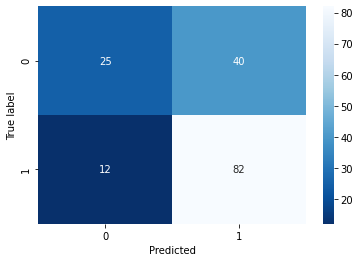

In [117]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
print('Accuracy = ', round(accuracy, 3))
print('Precision = ', round(precision, 3))
print('Recall = ', round(recall, 3))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r')
plt.ylabel('True label')
plt.xlabel('Predicted');

In [118]:
X.head(1)

,протеин,спо,порода,тип пастбища,порода быка,жирность,белок,возраст,экеКВ,спо_cat,имя папы
0,1743.0,0.89,Айдиал,равнинное,Айдиал,3.58,3.076,более_2_лет,201.64,Low,Буйный


In [119]:
cow_to_buy = cow_to_buy[cow_to_buy['удой']>= 6000]
cow_to_buy['экеКВ'] = cow_to_buy['эке'].apply(lambda x: x**2)
cow_to_buy['спо_cat'] = cow_to_buy['спо'].apply(lambda x: 'High' if x>0.92 else 'Low')
cow_to_buy = cow_to_buy[X.columns]
cow_to_buy.head(1)

,протеин,спо,порода,тип пастбища,порода быка,жирность,белок,возраст,экеКВ,спо_cat,имя папы
3,2019.227962,0.958469,Соверин,холмистое,Айдиал,3.4,3.061,более_2_лет,233.323453,High,Буйный


In [120]:
cow_buy_encode = encoder.transform(cow_to_buy[cat_col_names])
cow_buy_encode = pd.DataFrame(cow_buy_encode, columns=encode_names)


cow_buy_scaled = scaler_cat.transform(cow_to_buy[num_col_names])
cow_buy_scaled = pd.DataFrame(cow_buy_scaled, columns=num_col_names)
cow_to_buy = pd.concat([cow_buy_scaled, cow_buy_encode], axis=1)

In [121]:
cow_to_buy['вкус'] = clf.predict_proba(cow_to_buy)[:,1] >= 0.82
display(cow_to_buy)

,экеКВ,протеин,жирность,белок,спо,x0_Low,x1_Соверин,x2_холмистое,x3_менее_2_лет,x4_Соверин,вкус
0,0.558683,0.529692,-1.256639,-5.927080,1.425364,0.0,0.0,1.0,0.0,1.0,False
1,0.558683,0.529692,0.207916,-0.698352,1.425364,0.0,0.0,0.0,0.0,1.0,False
2,0.558683,0.529692,-1.256639,1.312698,1.425364,0.0,0.0,1.0,1.0,1.0,True
3,0.558683,0.529692,0.757125,-8.340339,1.425364,0.0,1.0,1.0,0.0,0.0,False
4,0.558683,0.529692,-1.256639,-4.318240,1.425364,0.0,0.0,1.0,0.0,1.0,False
5,0.558683,0.529692,0.757125,1.312698,1.425364,0.0,1.0,1.0,0.0,0.0,True
6,0.558683,0.529692,0.207916,-0.698352,1.425364,0.0,0.0,0.0,0.0,1.0,False


In [122]:
cow_to_buy[cow_to_buy['вкус'] == True]

,экеКВ,протеин,жирность,белок,спо,x0_Low,x1_Соверин,x2_холмистое,x3_менее_2_лет,x4_Соверин,вкус
2,0.558683,0.529692,-1.256639,1.312698,1.425364,0.0,0.0,1.0,1.0,1.0,True
5,0.558683,0.529692,0.757125,1.312698,1.425364,0.0,1.0,1.0,0.0,0.0,True


<div class="alert alert-warning">
<h2> Комментарий ревьюера  #3 <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации💡:</b> 

Да, есть недопонимание того, каким образом использовать скелер и энкодер. Прошу прощения, пропустил этот момент по линейной модели. 
    
***
 
На тренировочной выборке мы обучаем экнодер и скелер (кодирование и масштабирование). Мы говорим функции, какие у нас значения и в каком масштабе их менять (или какие у нас категории и как их разбивать).
    
Нам крайне важно, чтобы модель и училась на одних и тех же данных, и предсказывала. 
    
То есть, если у нас в тренировочной выборке было чего-то максимум в значении 10, то мы смасштабируем это 10 до единицы. И всегда будем масштабировать 10 в 1. 
    
Теперь, если мы обучим масштабироваться скелер заново на тестовой выборке, а там максимальное значение будет уже 20, тогда 10 из наших тестовых данных после масштабирования превратятся не в единицу, а в 0.5. То есть, изначальный признак, как мы обучили модель, был один, а в тесте он уже будет в другом искажении, но модель об этом ничего не знает. Она обучилась на тренировочных данных. Она будет выдавать неверное и неадекватное значение.
    
Правильно обучать скелер на тренировочной выборке, а применять его ко всем. К тесту мы применяем только transform, без fit. Также и при предсказании уже применяем только transform.
    
Та же самая история и с кодированием. Если будем обучать заново, то в зависимости от порядка категорий, которые попадутся в обучении энкодеру, будет порядок колонок. В итоге, если обучать заново, то тренировочная выборка не будет соответствовать тестовой по порядку колонок. Модель и в этом случае не сможет адекватно предсказывать.
    
```
X_train_scaled = scaler.fit_transform(X_train[num_col_names])
X_test_scaled = scaler.transform(X_test[num_col_names])
```

    
</div>

<div class='alert alert-info'>
    Хорошо спасибо за пояснение, извиняюсь за лишнюю эмоциональность.
</div>

## Итоговые выводы

<div style="border:solid Chocolate 2px; padding: 40px">

**Общий вывод по проекту**
    
Спасибо за твой проект! Это была достаточно объемная работа, требующая нахождения в контексте задачи, применения большого объема теоретических знаний.

    
**Отмечу положительные моменты проекта🚀**
    
* Хорошая структура проекта.
* Внимательная предобработка и подготовка признаков.
* Хорошие решения по коду
    
**На что стоит обратить внимание🤔**
    
* Не стоит удалять реалистичные данные, важно также отслеживать долю удаленных данных. У нас датасет маленький, важно все сохранять по максимуму.
* Важно использовать только корректный подход для замера корреляции.
* Необходимо избегать дамми-ловушки при энкодинге.
* Нужно уточнить по нелинейным связям признаков с таргетом.
* Нужно посчитать доверительный интервал.
* Важно уточнить по порогу и метрикам качества.
* Нужно применить порог.
* И не забудем про общий вывод.
    
По заданию проекта в общем выводе важно также дать рекомендации, как можем улучшить качество моделей.

Обрати внимание, у нас модель классификации имеет очень низкое качество. И кажется, нам не хватает входящих признаков для того, чтобы хорошо объяснить изменчивость таргета. Думаю, нужно это проговорить обязательно в общем выводе.     
    
  
* Эти и остальные замечания я также написал по ходу проекта.
    
**Желаю удачи и жду твой проект на повторное ревью!**😉
    
    
</div>

<div style="border:solid Chocolate 2px; padding: 40px">

**Комментарий ко второй проверке**

Спасибо за качественную доработку и за вопросы. Постарался ответить. Сейчас по проекту практически все верно. Однако еще кое-что осталось.

Важно доработать по предсказанию в задаче классификации. Нужно переставить колонки местами, привести таблицу на предсказание в соответствие с тем, на чем обучалась модель. В принципе, это действие было бы необязательным, если бы мы на этапе предобработки и работы над проектом выше все добавляли в том же порядке, но и исправить здесь это тоже не так уж и сложно. 
    
Дальше, судя по заготовкам кода, все делаешь верно. Предположу, что ни одна из коров не подойдет по вкусу, это ожидаемое решение. Не пугайся на этом моменте.
    
Если будут вопросы − задавай. Если будут проблемы с решением − присылай. Долго не сиди. У тебя хорошие верные вопросы, видно, что разбираешься и пытаешься разобраться. 

**Желаю удачи и жду твой проект на повторное ревью!**😉
</div>


<div style="border:solid Chocolate 2px; padding: 40px">

**Комментарий к третьей проверке**

Подсказал по решению с моделью классификации. Важно применять скелер и энкодер, обученные на тренировочной выборке.
    
Та же ошибка и в линейной модели, там предлагаю тебе уже все исправить самостоятельно, по аналогии с моделью классификации.

**Желаю удачи и жду твой проект на повторное ревью!**😉
</div>




<div style="border:solid Chocolate 2px; padding: 40px">

**Комментарий к финальной проверке**

Спасибо за доработку. Критичных комментариев нет. 

Если что-то пропустил или остались вопросы, напиши в телеграм @kriill

Желаю удачи в дальнейшей учебе!

</div>
